# ZNEUS Project 1: MLP - Alisa Podolska, Yulian Kisil

Dataset: https://www.kaggle.com/datasets/meirnizri/covid19-dataset?resource=download (57 MB)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats  
import warnings
import matplotlib
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

## Data analysis + predprocessing

What we did in this section:
### 1. Reading and Inspecting Data
- Loaded the dataset from `dataset.csv` using pandas.  
- Checked and corrected column names (renamed `CLASIFICATION_FINAL` → `CLASSIFICATION_FINAL`).  

---

### 2. Handling Duplicates
- Detected duplicate rows using `data.duplicated()`.  
- Removed all duplicates with `drop_duplicates()` to keep only unique records.  

---

### 3. Detecting and Replacing Missing Values
- Selected numeric columns, excluding `AGE` and `DATE_DIED`.  
- Replaced placeholder values `97` and `99` with NaN to mark them as missing data.  
- Calculated total and percentage of missing values for each column.  
- Visualized missing data using a bar plot.  

---

### 4. Removing Columns with Too Many Missing Values
- Identified columns with more than **40% missing values** (`INTUBED`, `PREGNANT`, `ICU`).  
- Dropped these columns using `dropna()` to improve dataset quality.  

---

### 5. Handling Columns with Few Missing Values
- Focused on the `PNEUMONIA` column, which had about **3% missing values**.  
- Analyzed the relationship between missing values and other features (like `AGE` and `SEX`).  
- Found that missing cases were closer to patients **without pneumonia (value 2)**.  
- Filled missing `PNEUMONIA` values with `2` instead of removing rows.  

---

### 6. Outlier Detection
- Used boxplots to visualize numeric features and detect potential outliers.  
- We didnt have outliers.  

---

### 7. Preventing Data Leakage
- Dropped the `DATE_DIED` column since it is dependent on the target variable (`CLASSIFICATION_FINAL`)  
  and could cause data leakage during model training.  

---

### 8. Final Clean Dataset
- The resulting dataset is cleaned and consistent.

---

### 9. Data Splitting
- The dataset was divided into three parts: **70% for training**, **15% for validation**, and **15% for testing**.  
- Stratified splitting was applied to keep the class distribution consistent across all subsets.  

---

### 10. Encoding Categorical Features
- Applied **one-hot encoding** to categorical columns (`SEX`, `PATIENT_TYPE`, `MEDICAL_UNIT`).  
- Renamed the resulting columns for clarity:
  - `SEX_2` → `IS_MALE`  
  - `PATIENT_TYPE_2` → `IS_HOSPITALIZED`  

---

### 11. Feature Scaling
- The `AGE` column was normalized using **Min-Max Scaling** to bring all values into the [0, 1] range.  
- The scaled distribution was visualized with a histogram to confirm proper normalization.  

---

### 12. Target Transformation
- The target variable `CLASSIFICATION_FINAL` was simplified to a **binary format**:  
  - Values **1–3 → 1** (positive COVID test)  
  - Values **4–7 → 0** (negative COVID test)  

---

### 13. Correlation Analysis
- A **correlation heatmap** was generated to identify relationships between numerical attributes.  
- This helped in spotting redundant or strongly related features.  

---

### 14. Hypothesis Testing
- Conducted a **Chi-Square test** to find dependencies between attributes and the target variable.  
- Found significant relationships for **PNEUMONIA**, **AGE**, and **IS_HOSPITALIZED**.  
- Rejected the null hypothesis and confirmed these features strongly influence patient classification.  

---

### 15. Final Remarks
- All features are now **numeric, scaled, and clean**.  
- The dataset is fully **ready for model training and evaluation**.


**1. Reading data**

In [2]:
data = pd.read_csv("dataset.csv", sep=',')
data.head()

USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  PNEUMONIA  \
0      2             1    1             1  03/05/2020       97          1   
1      2             1    2             1  03/06/2020       97          1   
2      2             1    2             2  09/06/2020        1          2   
3      2             1    1             1  12/06/2020       97          2   
4      2             1    2             1  21/06/2020       97          2   

   AGE  PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  HIPERTENSION  OTHER_DISEASE  \
0   65         2         2  ...       2        2             1              2   
1   72        97         2  ...       2        2             1              2   
2   55        97         1  ...       2        2             2              2   
3   53         2         2  ...       2        2             2              2   
4   68        97         1  ...       2        2             1              2   

   CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  TOBACCO  CLASIFFICATION_FINAL  ICU  
0               2        2              2        2                     3   97  
1               2        1              1        2                     5   97  
2               2        2              2        2                     3    2  
3               2        2              2        2                     7   97  
4               2        2              2        2                     3   97  

[5 rows x 21 columns]

In [3]:
data.rename(columns={'CLASIFFICATION_FINAL': 'CLASSIFICATION_FINAL'}, inplace=True)

**2. Deleting duplicities**

In [4]:
duplicates = data[data.duplicated()]
print("Duplicate Rows:")
print(duplicates)

Duplicate Rows:
         USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  \
19           2             1    1             1  9999-99-99       97   
35           2             1    2             1  9999-99-99       97   
62           2             1    1             2  9999-99-99        2   
63           2             1    2             1  9999-99-99       97   
75           2             1    1             1  9999-99-99       97   
...        ...           ...  ...           ...         ...      ...   
1048556      2            13    2             1  9999-99-99       97   
1048558      1            13    2             1  9999-99-99       97   
1048566      2            13    2             1  9999-99-99       97   
1048570      2            13    2             1  9999-99-99       97   
1048573      2            13    2             1  9999-99-99       97   

         PNEUMONIA  AGE  PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  \
19               2   64         2         2  ...  

In [5]:
duplicates.head()

USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  PNEUMONIA  \
19      2             1    1             1  9999-99-99       97          2   
35      2             1    2             1  9999-99-99       97          2   
62      2             1    1             2  9999-99-99        2          2   
63      2             1    2             1  9999-99-99       97          2   
75      2             1    1             1  9999-99-99       97          2   

    AGE  PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  HIPERTENSION  \
19   64         2         2  ...       2        2             2   
35   45        97         2  ...       2        2             2   
62   25         2         2  ...       2        2             2   
63   33        97         2  ...       2        2             2   
75   24         2         2  ...       2        2             2   

    OTHER_DISEASE  CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  TOBACCO  \
19              2               2        2              2        2   
35              2               2        2              2        2   
62              2               2        2              2        2   
63              2               2        2              2        2   
75              2               2        2              2        2   

    CLASSIFICATION_FINAL  ICU  
19                     3   97  
35                     3   97  
62                     7    2  
63                     7   97  
75                     7   97  

[5 rows x 21 columns]

In [6]:
data = data.drop_duplicates()

In [7]:
print(data)

         USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  \
0            2             1    1             1  03/05/2020       97   
1            2             1    2             1  03/06/2020       97   
2            2             1    2             2  09/06/2020        1   
3            2             1    1             1  12/06/2020       97   
4            2             1    2             1  21/06/2020       97   
...        ...           ...  ...           ...         ...      ...   
1048568      1            13    2             1  9999-99-99       97   
1048569      1            13    1             2  9999-99-99        2   
1048571      1            13    2             2  9999-99-99        2   
1048572      2            13    2             1  9999-99-99       97   
1048574      2            13    2             1  9999-99-99       97   

         PNEUMONIA  AGE  PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  \
0                1   65         2         2  ...       2        2 

**3. Detecting missing values**

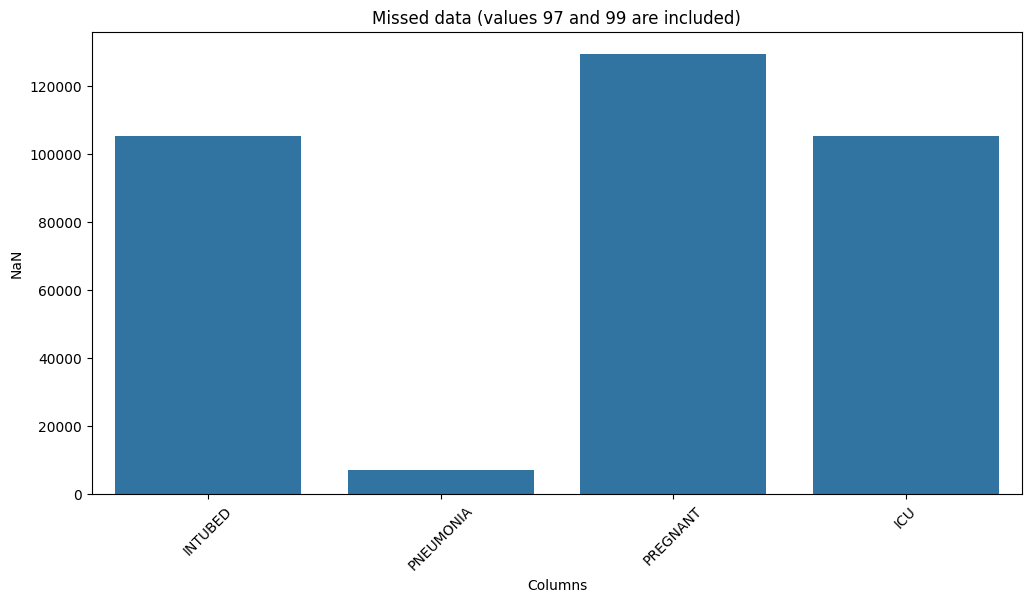

           Total NaN  Percentage NaN
INTUBED       105387       44.556201
PNEUMONIA       7187        3.038567
PREGNANT      129503       54.752120
ICU           105536       44.619196


In [8]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if 'DATE_DIED' in numeric_cols:
    numeric_cols.remove('DATE_DIED')
if 'AGE' in numeric_cols:
    numeric_cols.remove('AGE')
data[numeric_cols] = data[numeric_cols].replace([97, 99], np.nan)

nan_summary = data.isna().sum()
nan_percentage = (nan_summary / len(data)) * 100
nan_info = pd.DataFrame({'Total NaN': nan_summary, 'Percentage NaN': nan_percentage})
nan_info = nan_info[nan_info['Total NaN'] > 0]

plt.figure(figsize=(12, 6))
sns.barplot(x=nan_info.index, y='Total NaN', data=nan_info)
plt.xticks(rotation=45)
plt.ylabel('NaN')
plt.xlabel('Columns')
plt.title('Missed data (values 97 and 99 are included)')
plt.show()
print(nan_info)

**4. Colums with a lot of missing values (>40%) should be deleted**

In [9]:
data = data.dropna(axis=1, thresh=len(data) * 0.6)
print(data)

         USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  PNEUMONIA  AGE  \
0            2             1    1             1  03/05/2020        1.0   65   
1            2             1    2             1  03/06/2020        1.0   72   
2            2             1    2             2  09/06/2020        2.0   55   
3            2             1    1             1  12/06/2020        2.0   53   
4            2             1    2             1  21/06/2020        2.0   68   
...        ...           ...  ...           ...         ...        ...  ...   
1048568      1            13    2             1  9999-99-99        2.0   47   
1048569      1            13    1             2  9999-99-99        2.0   56   
1048571      1            13    2             2  9999-99-99        2.0   51   
1048572      2            13    2             1  9999-99-99        2.0   55   
1048574      2            13    2             1  9999-99-99        2.0   52   

         DIABETES  COPD  ASTHMA  INMSUPR  HIPERTENS

**5. Lets decide what to do with column where there is not so many missed values**

In [10]:
data = data[~data["PNEUMONIA"].isin([97, 99]) & data["PNEUMONIA"].notna()]


In [11]:
data[data['PNEUMONIA'].isna()]['SEX'].value_counts(normalize=True)

Series([], Name: proportion, dtype: float64)

In [12]:
data[data['PNEUMONIA'].isna()]['AGE'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: AGE, dtype: float64

In [13]:
data[data['PNEUMONIA']==1]['AGE'].describe()

count    99730.000000
mean        56.913707
std         17.717090
min          0.000000
25%         46.000000
50%         58.000000
75%         69.000000
max        120.000000
Name: AGE, dtype: float64

In [14]:
data[data['PNEUMONIA']==2]['AGE'].describe()

count    129609.000000
mean         49.853127
std          19.541605
min           0.000000
25%          36.000000
50%          50.000000
75%          64.000000
max         121.000000
Name: AGE, dtype: float64

We can see that mean of column Age with missing values of pneumonia and mean of column Age without pneumonia(value 2) is much more similar than people with pneumonia(value 1).
So to avoid deletion of 7187 records we changed it to values 2.

In [15]:
data['PNEUMONIA'].fillna(2, inplace=True)

**6. Outliers**

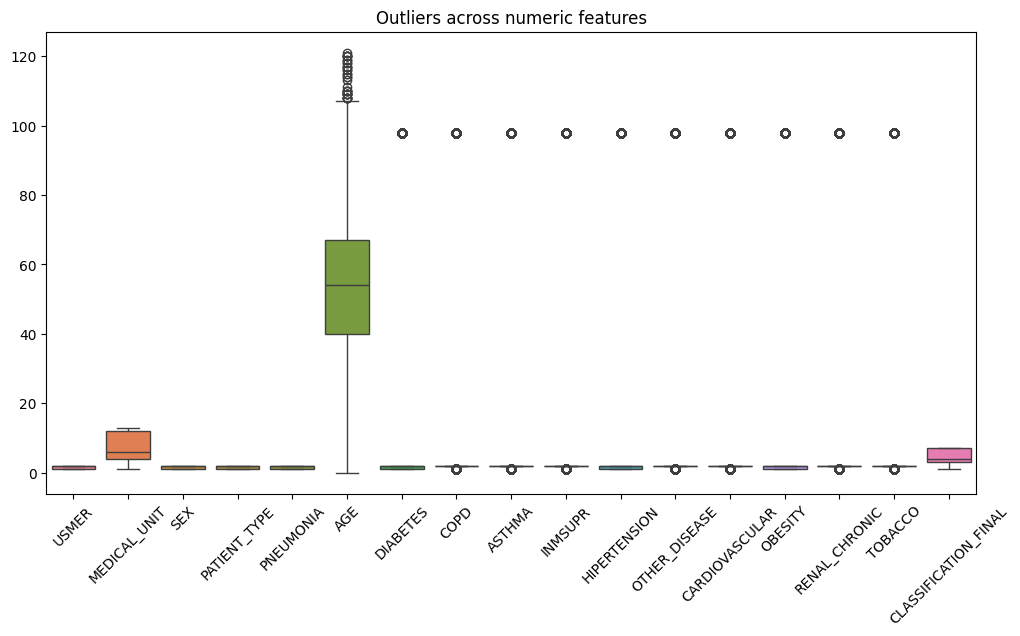

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data.select_dtypes(include=[np.number]))
plt.title('Outliers across numeric features')
plt.xticks(rotation=45)
plt.show()

**7. Data leakage**

Due too data leakage we should delete column: date_died. It is result after out target value. We cannot use it to classify new data.

In [17]:
data = data.drop(columns=['DATE_DIED'])

## Data analysis on cleaned data

In [18]:
print(f"Record count: {data.shape[0]}, Attribute count: {data.shape[1]}\n{data.dtypes}")

Record count: 229339, Attribute count: 17
USMER                     int64
MEDICAL_UNIT              int64
SEX                       int64
PATIENT_TYPE              int64
PNEUMONIA               float64
AGE                       int64
DIABETES                  int64
COPD                      int64
ASTHMA                    int64
INMSUPR                   int64
HIPERTENSION              int64
OTHER_DISEASE             int64
CARDIOVASCULAR            int64
OBESITY                   int64
RENAL_CHRONIC             int64
TOBACCO                   int64
CLASSIFICATION_FINAL      int64
dtype: object


In [19]:
data['PNEUMONIA'] = data['PNEUMONIA'].astype(int)

**Distribution of column AGE**

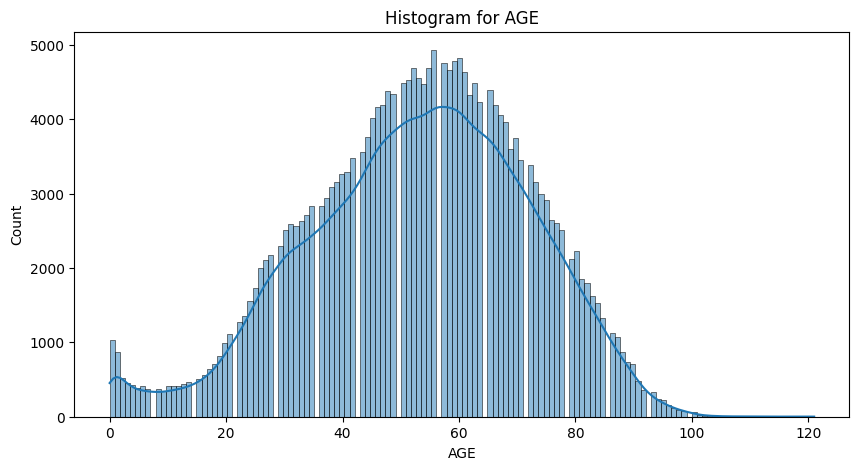

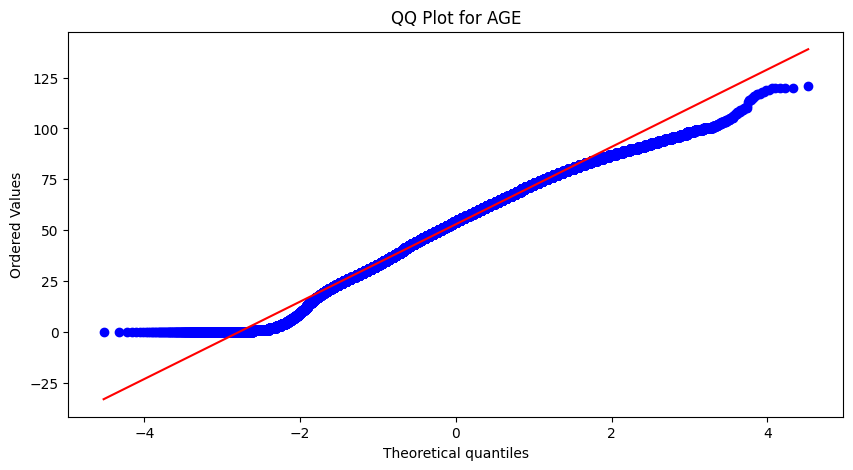

Shapiro-Wilk Test for AGE: Stat=0.991, p-value=0.000
The distribution of AGE is not normal.



In [20]:
plt.figure(figsize=(10, 5))
sns.histplot(data['AGE'], kde=True)
plt.title(f'Histogram for AGE')
plt.show()

plt.figure(figsize=(10, 5))
stats.probplot(data['AGE'], dist="norm", plot=plt)
plt.title(f'QQ Plot for AGE')
plt.show()

stat, p_value = stats.shapiro(data['AGE'])
print(f'Shapiro-Wilk Test for AGE: Stat={stat:.3f}, p-value={p_value:.3f}')
    
if p_value > 0.05:
    print(f'The distribution of AGE is normal.\n')
else:
    print(f'The distribution of AGE is not normal.\n')

In [21]:
data_MC = data.copy()

## Data split

The dataset divided into three parts:

70% for training,

15% for validation,

15% for testing.

In [22]:
X = data.drop(columns=['CLASSIFICATION_FINAL'])
y = data['CLASSIFICATION_FINAL']

In [23]:
val_size = 0.15
test_size = 0.15

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=test_size, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size / (1 - test_size),
    stratify=y_temp, random_state=42
)


## Data normalization

All columns with values 1 and 2 were converted into binary format.

In [24]:
binary_cols = ['PNEUMONIA', 'DIABETES', 'INMSUPR', 'OTHER_DISEASE', 'TOBACCO', 'RENAL_CHRONIC', 'OBESITY', 'CARDIOVASCULAR', 'HIPERTENSION', 'ASTHMA', 'COPD']
data[binary_cols] = data[binary_cols].replace({2: 0})
X_train[binary_cols] = X_train[binary_cols].replace({2: 0})
X_val[binary_cols] = X_val[binary_cols].replace({2: 0})
X_test[binary_cols] = X_test[binary_cols].replace({2: 0})



All categorical features were transformed using one-hot encoding.

In [25]:
categorical_cols = ['SEX', 'PATIENT_TYPE', 'MEDICAL_UNIT']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True, dtype=int)
X_val = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True, dtype=int)
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True, dtype=int)


data = data.rename(columns={
    'SEX_2': 'IS_MALE',
    'PATIENT_TYPE_2': 'IS_HOSPITALIZED'
})
X_test = X_test.rename(columns={
    'SEX_2': 'IS_MALE',
    'PATIENT_TYPE_2': 'IS_HOSPITALIZED'
})
X_val = X_val.rename(columns={
    'SEX_2': 'IS_MALE',
    'PATIENT_TYPE_2': 'IS_HOSPITALIZED'
})
X_train = X_train.rename(columns={
    'SEX_2': 'IS_MALE',
    'PATIENT_TYPE_2': 'IS_HOSPITALIZED'
})

AGE column was normalized using the Min-Max Scaler.

In [26]:
scaler = MinMaxScaler()
data['AGE'] = scaler.fit_transform(data[['AGE']])
X_test['AGE'] = scaler.fit_transform(X_test[['AGE']])
X_val['AGE'] = scaler.fit_transform(X_val[['AGE']])
X_train['AGE'] = scaler.fit_transform(X_train[['AGE']])

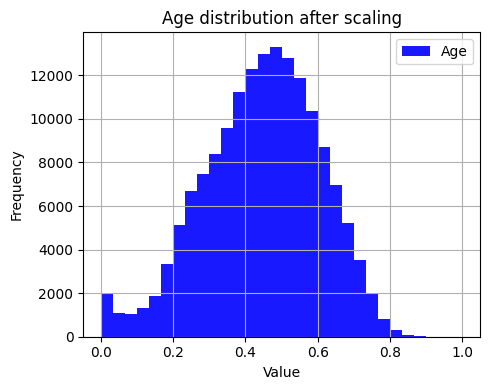

In [27]:
plt.figure(figsize=(5, 4)) 
plt.hist(X_train['AGE'], bins=30, alpha=0.9, color='blue')
plt.title("Age distribution after scaling")  
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend(["Age"])
plt.grid()
plt.tight_layout()
plt.show()

Target column is changed 
- 1–3 → 1 (positive COVID test)
- 4–7 → 0 (negative COVID test)

In [28]:
data['CLASSIFICATION_FINAL'] = data['CLASSIFICATION_FINAL'].apply(lambda x: 1 if x in [1, 2, 3] else 0)
y_train = y_train.apply(lambda x: 1 if x in [1, 2, 3] else 0)
y_val = y_val.apply(lambda x: 1 if x in [1, 2, 3] else 0)
y_test = y_test.apply(lambda x: 1 if x in [1, 2, 3] else 0)

In [29]:
y_train.head()

140755    1
59453     1
480496    1
741383    0
234507    0
Name: CLASSIFICATION_FINAL, dtype: int64

In [30]:
print(len(y_train))
print(f"Train record count: {X_train.shape[0]}, Attribute count: {X_train.shape[1]}\n{X_train.dtypes}")

160537
Train record count: 160537, Attribute count: 27
USMER                int64
PNEUMONIA            int64
AGE                float64
DIABETES             int64
COPD                 int64
ASTHMA               int64
INMSUPR              int64
HIPERTENSION         int64
OTHER_DISEASE        int64
CARDIOVASCULAR       int64
OBESITY              int64
RENAL_CHRONIC        int64
TOBACCO              int64
IS_MALE              int64
IS_HOSPITALIZED      int64
MEDICAL_UNIT_2       int64
MEDICAL_UNIT_3       int64
MEDICAL_UNIT_4       int64
MEDICAL_UNIT_5       int64
MEDICAL_UNIT_6       int64
MEDICAL_UNIT_7       int64
MEDICAL_UNIT_8       int64
MEDICAL_UNIT_9       int64
MEDICAL_UNIT_10      int64
MEDICAL_UNIT_11      int64
MEDICAL_UNIT_12      int64
MEDICAL_UNIT_13      int64
dtype: object


In [31]:
print(len(y_test))
print(f"Test record count: {X_test.shape[0]}, Attribute count: {X_test.shape[1]}\n{X_test.dtypes}")

34401
Test record count: 34401, Attribute count: 27
USMER                int64
PNEUMONIA            int64
AGE                float64
DIABETES             int64
COPD                 int64
ASTHMA               int64
INMSUPR              int64
HIPERTENSION         int64
OTHER_DISEASE        int64
CARDIOVASCULAR       int64
OBESITY              int64
RENAL_CHRONIC        int64
TOBACCO              int64
IS_MALE              int64
IS_HOSPITALIZED      int64
MEDICAL_UNIT_2       int64
MEDICAL_UNIT_3       int64
MEDICAL_UNIT_4       int64
MEDICAL_UNIT_5       int64
MEDICAL_UNIT_6       int64
MEDICAL_UNIT_7       int64
MEDICAL_UNIT_8       int64
MEDICAL_UNIT_9       int64
MEDICAL_UNIT_10      int64
MEDICAL_UNIT_11      int64
MEDICAL_UNIT_12      int64
MEDICAL_UNIT_13      int64
dtype: object


In [32]:
print(len(y_val))
print(f"Val record count: {X_val.shape[0]}, Attribute count: {X_val.shape[1]}\n{X_val.dtypes}")

34401
Val record count: 34401, Attribute count: 27
USMER                int64
PNEUMONIA            int64
AGE                float64
DIABETES             int64
COPD                 int64
ASTHMA               int64
INMSUPR              int64
HIPERTENSION         int64
OTHER_DISEASE        int64
CARDIOVASCULAR       int64
OBESITY              int64
RENAL_CHRONIC        int64
TOBACCO              int64
IS_MALE              int64
IS_HOSPITALIZED      int64
MEDICAL_UNIT_2       int64
MEDICAL_UNIT_3       int64
MEDICAL_UNIT_4       int64
MEDICAL_UNIT_5       int64
MEDICAL_UNIT_6       int64
MEDICAL_UNIT_7       int64
MEDICAL_UNIT_8       int64
MEDICAL_UNIT_9       int64
MEDICAL_UNIT_10      int64
MEDICAL_UNIT_11      int64
MEDICAL_UNIT_12      int64
MEDICAL_UNIT_13      int64
dtype: object


In [33]:
data

USMER  PNEUMONIA       AGE  DIABETES  COPD  ASTHMA  INMSUPR  \
0            2          1  0.537190         0     0       0        0   
1            2          1  0.595041         0     0       0        0   
2            2          0  0.454545         1     0       0        0   
3            2          0  0.438017         0     0       0        0   
4            2          0  0.561983         1     0       0        0   
...        ...        ...       ...       ...   ...     ...      ...   
1048568      1          0  0.388430         1     0       0        0   
1048569      1          0  0.462810         1     0       0        0   
1048571      1          0  0.421488         0     0       0        0   
1048572      2          0  0.454545         0     0       0        0   
1048574      2          0  0.429752         0     0       0        0   

         HIPERTENSION  OTHER_DISEASE  CARDIOVASCULAR  ...  MEDICAL_UNIT_4  \
0                   1              0               0  ...               0   
1                   1              0               0  ...               0   
2                   0              0               0  ...               0   
3                   0              0               0  ...               0   
4                   1              0               0  ...               0   
...               ...            ...             ...  ...             ...   
1048568             0              0               0  ...               0   
1048569             0              0               0  ...               0   
1048571             1              0               0  ...               0   
1048572             0              0               0  ...               0   
1048574             0              0               0  ...               0   

         MEDICAL_UNIT_5  MEDICAL_UNIT_6  MEDICAL_UNIT_7  MEDICAL_UNIT_8  \
0                     0               0               0               0   
1                     0               0               0               0   
2                     0               0               0               0   
3                     0               0               0               0   
4                     0               0               0               0   
...                 ...             ...             ...             ...   
1048568               0               0               0               0   
1048569               0               0               0               0   
1048571               0               0               0               0   
1048572               0               0               0               0   
1048574               0               0               0               0   

         MEDICAL_UNIT_9  MEDICAL_UNIT_10  MEDICAL_UNIT_11  MEDICAL_UNIT_12  \
0                     0                0                0                0   
1                     0                0                0                0   
2                     0                0                0                0   
3                     0                0                0                0   
4                     0                0                0                0   
...                 ...              ...              ...              ...   
1048568               0                0                0                0   
1048569               0                0                0                0   
1048571               0                0                0                0   
1048572               0                0                0                0   
1048574               0                0                0                0   

         MEDICAL_UNIT_13  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
...                  ...  
1048568                1  
1048569                1  
1048571                1  
1048572                1  
1048574                1  

[229339 rows x 28 columns]

Lets look on correlation between attributes on normalized data

<Axes: >

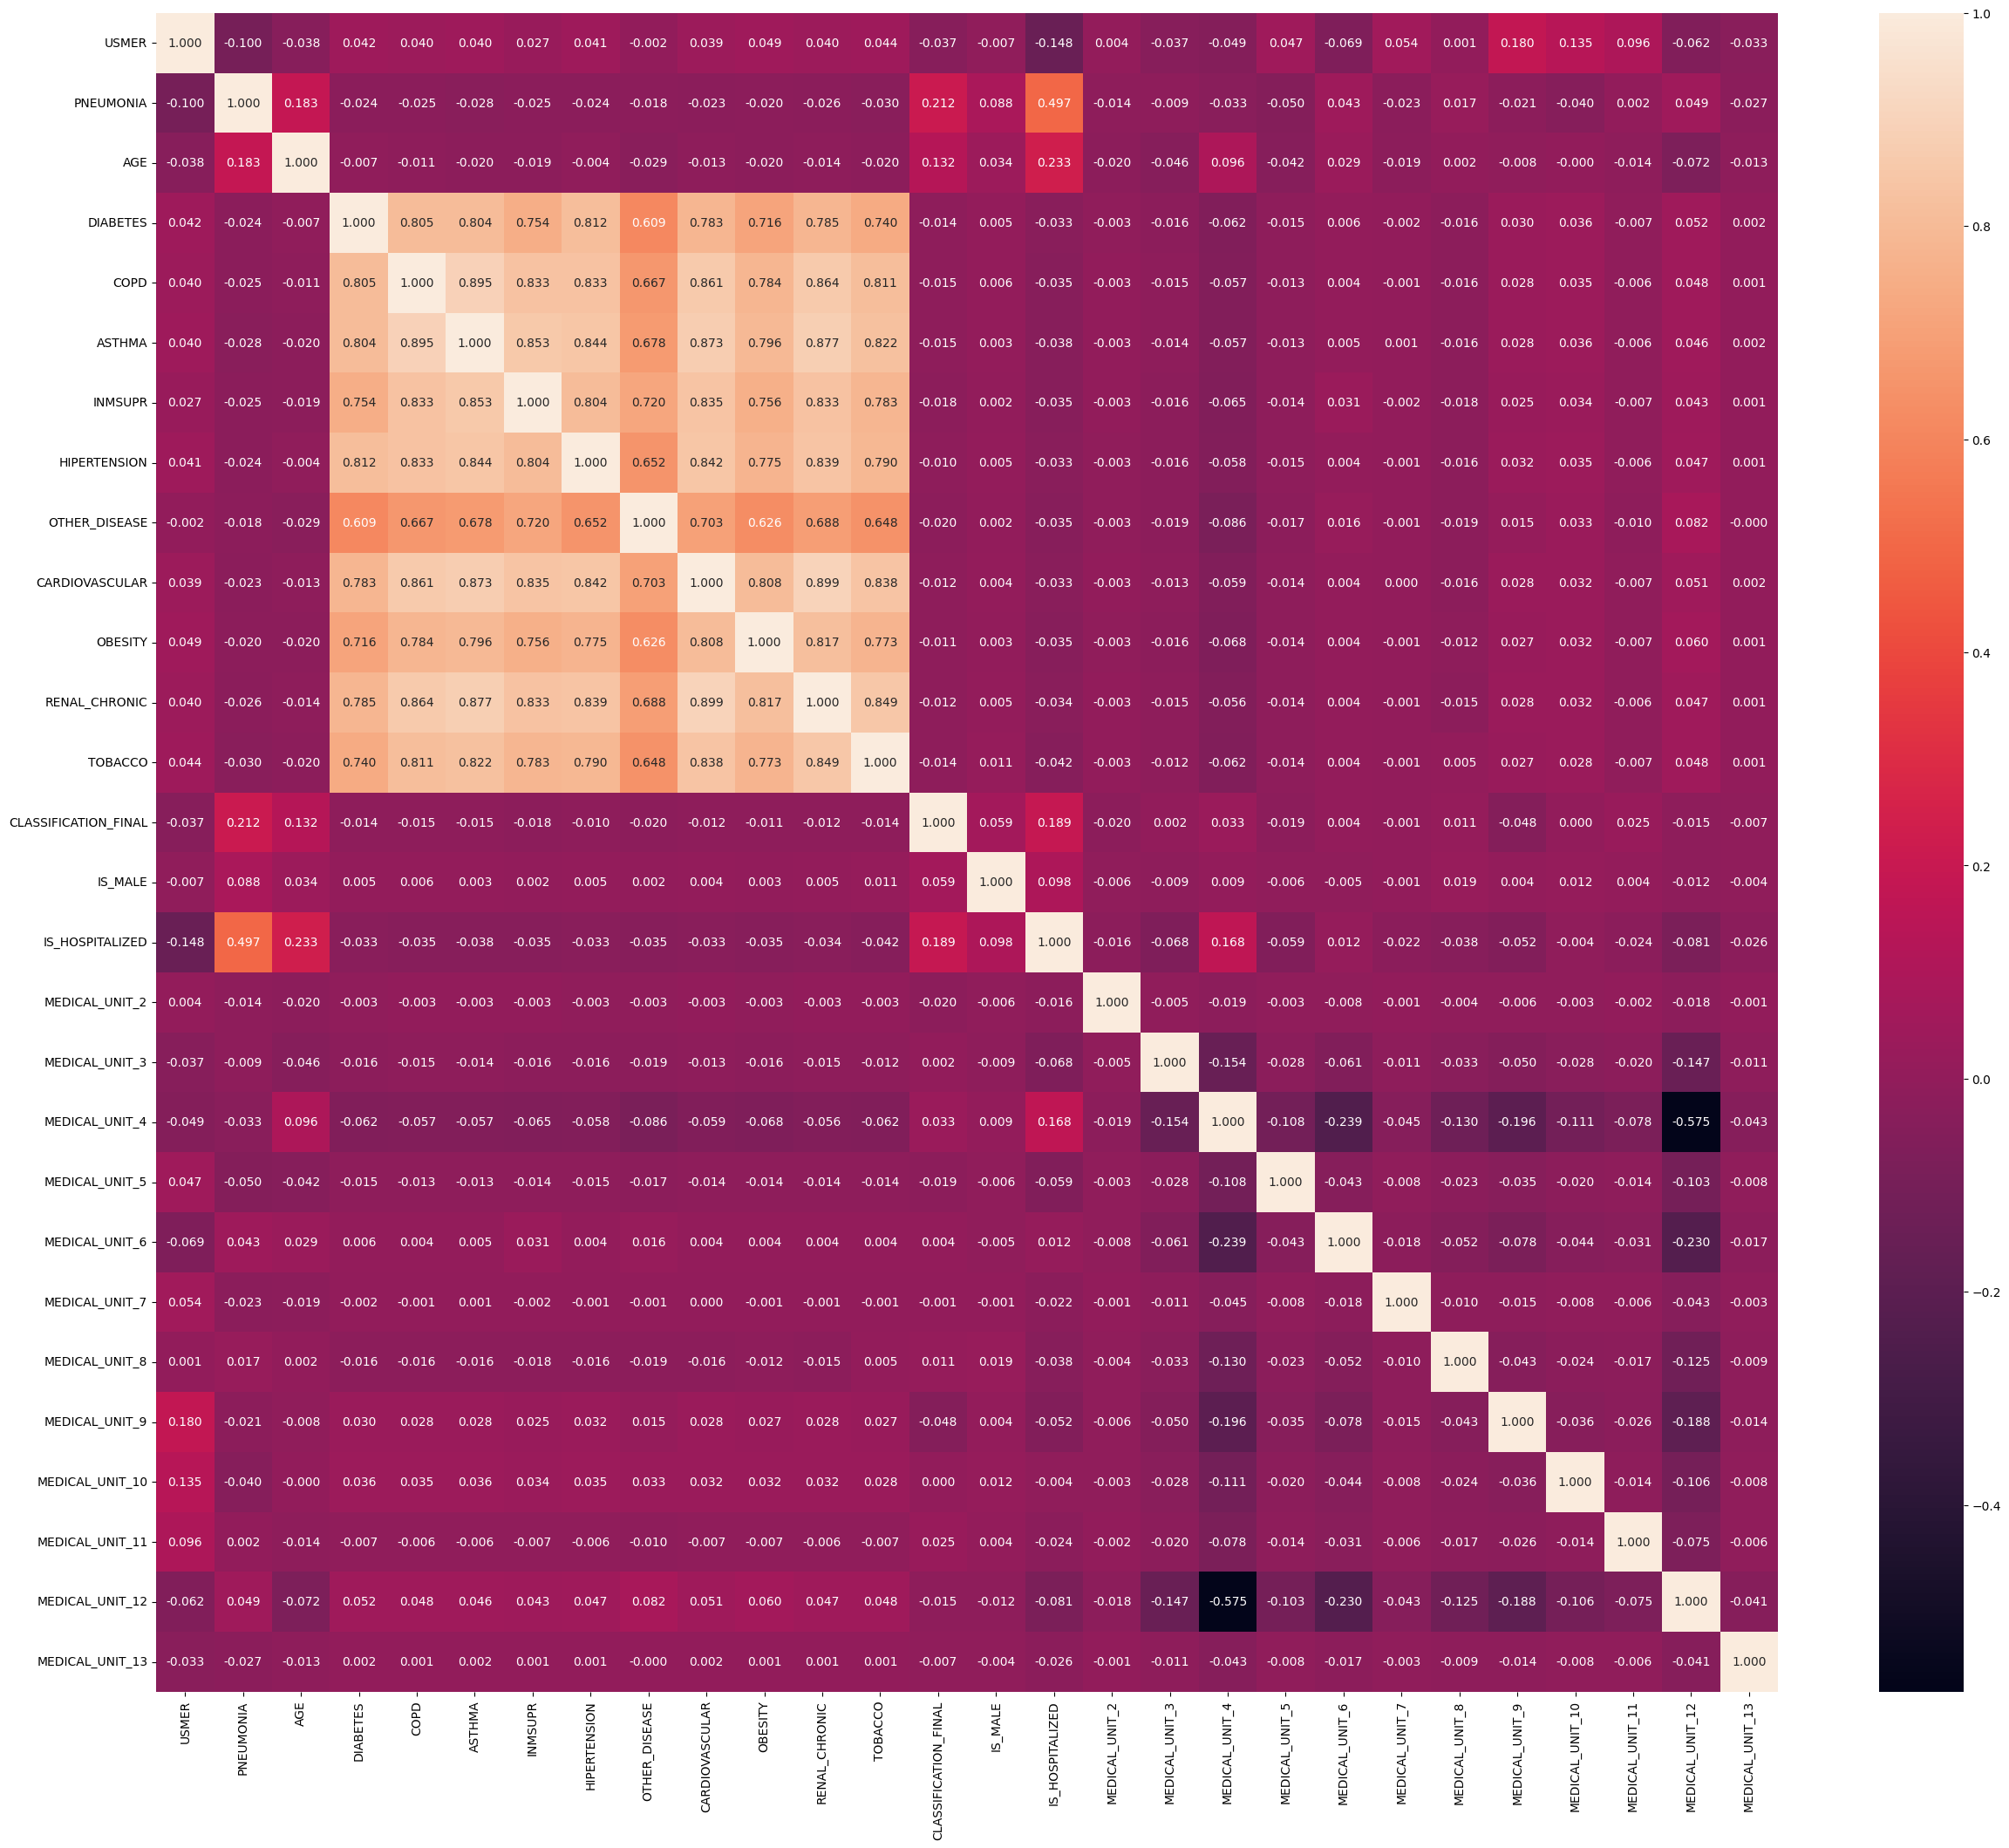

In [34]:
fig, ax = plt.subplots(figsize=(30,25))
sns.heatmap(data.corr(), ax=ax, annot=True, fmt=".3f")

Main attributes (have the biggest dependencies with our target value CLASSIFICATION_FINAL) are: **PNEUMONIA, AGE, IS_HOSPITALIZED**

**Hypothesis**

Null Hypothesis (**H0**):

The attributes: PNEUMONIA, AGE, IS_HOSPITALIZED and classification_final are independent.
The presence of attributes is not associated with the level of patient classification.

Alternative Hypothesis (**H1**):

The attributes: PNEUMONIA, AGE, IS_HOSPITALIZED are dependent.
The presence of attributes is associated with the level of patient classification.

In [35]:
cols = ['AGE', 'IS_HOSPITALIZED', 'PNEUMONIA'] 
target = 'CLASSIFICATION_FINAL'

for col in cols:
    table = pd.crosstab(data[col], data[target])
    chi2, p, dof, expected = chi2_contingency(table)
    
    print(f"Chi-Square test for {col}")
    print(f"Test result {chi2:.3f}, p-value = {p:.5f}, dof = {dof}")
    
    if p < 0.05:
        print(f"There IS a significant relationship between {col} and {target}.\n")
    else:
        print(f"There is NO significant relationship between {col} and {target}.\n")

Chi-Square test for AGE
Test result 6235.315, p-value = 0.00000, dof = 120
There IS a significant relationship between AGE and CLASSIFICATION_FINAL.

Chi-Square test for IS_HOSPITALIZED
Test result 8195.963, p-value = 0.00000, dof = 1
There IS a significant relationship between IS_HOSPITALIZED and CLASSIFICATION_FINAL.

Chi-Square test for PNEUMONIA
Test result 10298.019, p-value = 0.00000, dof = 1
There IS a significant relationship between PNEUMONIA and CLASSIFICATION_FINAL.



The Chi-Square test results show that `PNEUMONIA`, `AGE`, and `IS_HOSPITALIZED` are strongly related to **CLASSIFICATION_FINAL**.
Since all **p-values** are very small (0.00000), we can say these attributes are not independent — they actually affect how patients are classified.
So, we **reject** the **null hypothesis** and **accept** the **alternative** one: these factors really matter for the patient classification.

**The data normalization process has been completed.
As a result, all features are now numerical and scaled.**

**Our dataset is fully ready to be fed into the model.**

## Configuration

This cell creates a configuration for training a baseline MLP model.
It defines model structure (layers, activation, dropout, BN),
training parameters (batch size, epochs, learning rate, early stopping),
and experiment metadata. The config is saved to and loaded from a JSON file.

In [36]:
import json

config_data = {
    "model": {
        "input_dim": 27,
        "hidden_layers": [128, 64, 32],
        "activation": "relu",
        "output_activation": "sigmoid",
        "dropout_rate": 0.3,
        "batch_norm": True,
        "skip_connection": False,
        "bottleneck": False
    },
    "training": {
        "batch_size": 64,
        "epochs": 30,
        "learning_rate": 0.001,
        "optimizer": "adam",
        "early_stopping": True,
        "patience": 5
    },
    "experiment": {
        "name": "baseline_mlp_dropout_bn",
        "description": "Baseline model with dropout and BN"
    }
}

with open("config.json", "w") as f:
    json.dump(config_data, f, indent=4)

with open("config.json", "r") as f:
    config = json.load(f)

## Experiment tracking

This cell defines a helper function for saving experiment results.
It stores the model’s metrics, configuration, experiment name, and timestamp
in a JSON file called "experiments_log.json".

If the file already exists, the new result is added to it. This helps compare
different experiments later.


In [37]:
from datetime import datetime


def log_experiment(metrics, config, filename="experiments_log.json"):
    entry = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "experiment_name": config["experiment"]["name"],
        "description": config["experiment"]["description"],
        "config": config,
        "metrics": metrics
    }

    try:
        with open(filename, "r") as f:
            logs = json.load(f)
    except FileNotFoundError:
        logs = []

    logs.append(entry)
    with open(filename, "w") as f:
        json.dump(logs, f, indent=4)

## Experiments - meaningful based on the results of previous experiments
## Including improvement techniques (e.g. Dropout, Normalization layers, Skip Connections, Bottleneck Layers, …)

 This cell checks class distribution in the training set
 and creates class weights if the dataset is imbalanced.
 Class weights help the model pay more attention to the minority class.


In [38]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, optimizers
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import wandb
import os

### Custom MLP Builder — Static vs Configurable Model

In our project we use **two versions of the MLP model**:

- **1) Static model (`build_mlp_a`)**  
  This one has a fixed architecture (512 → 256 → 128 → 64 → output).  
  We mainly keep it as a baseline to compare with the configurable model.

- **2) Configurable model (`build_mlp`)**  
  This model is built dynamically from a config dictionary or JSON file.  
  Here we can easily change number of layers, activation functions, dropout, batch norm, etc.  
  This is super useful when we run experiments (e.g. with W&B or saved `.json` configs) and want to reproduce them without rewriting code.

---

### Why we need `normalize_model_cfg()`

The function `normalize_model_cfg()` basically makes sure the configuration is always a **standard Python dict**, no matter where it comes from:

 `.json` file  
 W&B `config` object  
 Custom Python class with `.to_dict()`  
 Even TensorFlow/Keras `.to_json()` format

This allows us to load the model settings from **JSON / wandb / other sources** and build the network automatically without errors.

---

###  What `build_mlp()` actually does

- Takes the config from `normalize_model_cfg()`  
- Builds the network layer by layer (Dense → Activation → BatchNorm → Dropout)  
- Supports:
  - variable number of hidden layers (`hidden_layers=[256,128,64,...]`)
  - optional skip-connections every 2 layers
  - optional bottleneck layer
  - binary output (`sigmoid`) or multi-class (`softmax`)

---

In short:  
**`build_mlp_a` = fixed model**  
**`build_mlp`  = flexible model from config**  
**`normalize_model_cfg` = makes sure configs from JSON or W&B work the same way**



In [39]:
from collections.abc import Mapping
import json

def build_mlp_a(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(512, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(1e-5))(inputs)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, kernel_initializer="he_normal")(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, kernel_initializer="he_normal")(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, kernel_initializer="he_normal")(x)
    x = layers.LeakyReLU(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)


def normalize_model_cfg(raw_cfg):
    if raw_cfg is None:
        raise ValueError("Model configuration is required.")

    if isinstance(raw_cfg, Mapping):
        return dict(raw_cfg)

    for attr_name in ("as_dict", "to_dict"):
        getter = getattr(raw_cfg, attr_name, None)
        if callable(getter):
            cfg = getter()
            if isinstance(cfg, Mapping):
                return dict(cfg)
            return cfg

    to_json = getattr(raw_cfg, "to_json", None)
    if callable(to_json):
        return json.loads(to_json())

    if hasattr(raw_cfg, "__dict__"):
        return {k: v for k, v in vars(raw_cfg).items() if not k.startswith("_")}

    raise TypeError(f"Unsupported model config type: {type(raw_cfg)}")


def build_mlp(raw_cfg, num_classes=1, show_summary=True):
    cfg = normalize_model_cfg(raw_cfg)

    input_dim = cfg["input_dim"]
    hidden_layers = cfg.get("hidden_layers", [])
    activation = cfg.get("activation", "relu")
    output_activation = cfg.get("output_activation", "sigmoid")
    dropout_rate = cfg.get("dropout_rate", 0.0)
    batch_norm = cfg.get("batch_norm", False)
    skip_connection = cfg.get("skip_connection", False)
    bottleneck = cfg.get("bottleneck", False)

    if num_classes > 1:
        output_activation = "softmax"
        
    inputs = layers.Input(shape=(input_dim,))
    x = inputs
    skips = []

    for i, units in enumerate(hidden_layers):
        x = layers.Dense(units, activation=activation)(x)
        if batch_norm:
            x = layers.BatchNormalization()(x)
        if dropout_rate and dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
        if skip_connection and i % 2 == 0:
            if skips and x.shape[-1] == skips[-1].shape[-1]:
                x = layers.Add()([x, skips[-1]])
            skips.append(x)

    if bottleneck:
        x = layers.Dense(16, activation=activation)(x)

    outputs = layers.Dense(num_classes, activation=output_activation)(x)
    model = tf.keras.Model(inputs, outputs)
    if show_summary:
        model.summary()
    return model

## **Experiments with wandb**

### `train_experiment()` – Training Function with Weights & Biases (W&B)

This function is responsible for training the neural network, logging results to Weights & Biases (W&B), and managing the whole experiment process. It includes model creation, optimizer selection, training loop, metric calculation, and logging.

---

#### 1. Initializing the W&B experiment

At the beginning of the function, a new W&B run is started.  
All parameters passed into the function (learning rate, batch size, dropout, hidden layers, etc.) are automatically stored in `wandb.config`.  
This makes it easy to reproduce or compare experiments later.

---

#### 2. Choosing the model type

There are two types of models in our project:

- **Static model (`build_mlp_a`)** – fixed architecture, always the same structure.
- **Configurable model (`build_mlp`)** – the architecture is built from a configuration (JSON or W&B config), where we can change the number of layers, activation functions, dropout, etc.

Based on the `model_type` argument, the function selects which model to build.  
The optimizer is also selected here (Adam, AdamW, or SGD).

---

#### 3. Compiling the model

```python
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])


In [40]:
def train_experiment(
    project_name="covid_classification",
    experiment_name="default_run",
    model_type="a",
    input_dim=27,
    hidden_layers=[128, 64, 32],
    activation="relu",
    output_activation="sigmoid",
    dropout_rate=0.3,
    batch_norm=True,
    bottleneck=False,
    batch_size=64,
    epochs=30,
    learning_rate=1e-3,
    optimizer_type="adam",
    patience=5,
    weight_decay=1e-5,
    smooth_weight=0.8
):

    os.environ["WANDB_START_METHOD"] = "thread"
    wandb.init(
        project=project_name,
        name=experiment_name,
        config=locals(),
        settings=wandb.Settings(start_method="thread", init_timeout=300)
    )

    cfg = wandb.config
    model_cfg = normalize_model_cfg(cfg)

    if model_type == "a":
        model = build_mlp_a(input_dim)
        opt = AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    else:
        model = build_mlp(model_cfg, show_summary=False)
        if optimizer_type.lower() == "adamw":
            opt = AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
        elif optimizer_type.lower() == "adam":
            opt = optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_type.lower() == "sgd":
            opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
        else:
            raise ValueError("Unsupported optimizer")

    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    cb = [
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
        callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
    ]

    for epoch in range(cfg.epochs):
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=1,
            batch_size=cfg.batch_size,
            verbose=0,
            callbacks=cb
        )

        y_pred = (model.predict(X_val, verbose=0) > 0.5).astype(int).ravel()
        y_true = np.array(y_val).astype(int).ravel()

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        wandb.log({
            "epoch": epoch + 1,
            "loss": history.history["loss"][0],
            "val_loss": history.history["val_loss"][0],
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "learning_rate": model.optimizer.learning_rate.numpy()
        })

    wandb.finish()
    return model


### Experiment Overview

Below are the experiments we ran using the `train_experiment()` function.  
Each experiment tests a different model configuration or optimizer setup to compare performance.


###  Overview of All Training Experiments

| Experiment Name        | Model Type | Optimizer | LR      | BatchNorm | Dropout | Bottleneck | Notes |
|------------------------|------------|-----------|---------|-----------|---------|------------|-------|
| `test`                 | Config (`b`) | AdamW     | 1e-4    | Yes       | Default | No         | Baseline configurable model. Used as the main reference. |
| `test_a_model`         | Static (`a`) | AdamW     | 1e-4    | Yes       | Yes     | No         | Fixed architecture MLP (build_mlp_a). Used to compare static vs configurable models. |
| `test_no_bn_dropout`   | Config (`b`) | Adam      | 1e-3    | No        | 0.0     | No         | No batch normalization and no dropout. Tests model without regularization. |
| `test_bottleneck`      | Config (`b`) | AdamW     | 1e-4    | Yes       | 0.2     | Yes        | Adds bottleneck layer to compress features before output. |
| `test_sgd_momentum`    | Config (`b`) | SGD       | 5e-3    | Yes       | 0.3     | No         | Uses SGD with momentum instead of Adam-based optimizers. |


In [ ]:
model = train_experiment(
    experiment_name="test",
    model_type="b",
    optimizer_type="adamw",
    learning_rate=1e-4,
    epochs=40
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: podolskyna (podolskyna-slovak-university-of-technology). Use `wandb login --relogin` to force relogin


In [ ]:
model_a = train_experiment(
    experiment_name="test_a_model",
    model_type="a",
    optimizer_type="adamw",
    learning_rate=1e-4,
    epochs=40
)

In [ ]:
model2 = train_experiment(
    experiment_name="test_no_bn_dropout",
    model_type="b",
    optimizer_type="adam",        
    learning_rate=1e-3,
    batch_norm=False, 
    dropout_rate=0.0,
    epochs=40
)

In [48]:
model3 = train_experiment(
    experiment_name="test_bottleneck",
    model_type="b",
    optimizer_type="adamw",
    learning_rate=1e-4,
    bottleneck=True,
    batch_norm=True,
    dropout_rate=0.2,
    epochs=40
)

In [49]:
model4 = train_experiment(
    experiment_name="test_sgd_momentum",
    model_type="b",
    optimizer_type="sgd",
    learning_rate=5e-3,
    batch_norm=True,
    dropout_rate=0.3,
    epochs=40
)

# **Experiments on Jupyter notebook**

This block calculates class weights for imbalanced data.
Class weights help the model pay more attention to the minority class during training.

In [41]:
print("Class balance in y_train:", y_train.value_counts(normalize=True))
if (y_train == 1).mean() < 0.4 or (y_train == 1).mean() > 0.6:
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
else:
    class_weight_dict = None
    print("Classes are balanced, no class_weight needed.")

Class balance in y_train: CLASSIFICATION_FINAL
0    0.506039
1    0.493961
Name: proportion, dtype: float64
Classes are balanced, no class_weight needed.


 ### This block defines a reusable functions to run experiments


In [42]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc as sk_auc

#### Function: `build_and_compile_model(config)`
Creates an MLP model using parameters from `config["model"]`.  
Then compiles it with Adam optimizer, binary cross-entropy loss and metrics like accuracy, AUC, precision and recall.

In [43]:
def build_and_compile_model(config):
    model_cfg = config["model"]
    model = build_mlp(model_cfg)
    optimizer = optimizers.Adam(learning_rate=config["training"]["learning_rate"])
    model.compile(optimizer=optimizer, loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    return model

#### Function: `train_model(model, train_cfg, X_train, y_train, X_val, y_val, class_weight=None)`
Trains the compiled model on the training set.  
Uses validation data and EarlyStopping if it's enabled in the config.  
Returns the `history` object from Keras.

In [44]:
def train_model(model, train_cfg, X_train, y_train, X_val, y_val, class_weight=None):
    callbacks = []
    if train_cfg["early_stopping"]:
        callbacks.append(EarlyStopping(monitor="val_loss", patience=train_cfg["patience"],
                                       restore_best_weights=True))
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=train_cfg["epochs"],
        batch_size=train_cfg["batch_size"],
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=0
    )
    return history

#### Function: `analyze_history(history)`
Converts training history into a DataFrame and prints useful stats:  
- Min validation loss  
- Best validation accuracy, AUC, precision, recall  
Helps to understand at which epoch the model performed best.

In [45]:
def analyze_history(history):
    history_df = pd.DataFrame(history.history)
    print("Training History Summary:")
    print(history_df.describe())
    print("\nBest Validation Metrics:")
    print(f"Best Val Loss: {history_df['val_loss'].min():.4f} at epoch {history_df['val_loss'].idxmin() + 1}")
    print(f"Best Val Accuracy: {history_df['val_accuracy'].max():.4f} at epoch {history_df['val_accuracy'].idxmax() + 1}")
    print(f"Best Val AUC: {history_df['val_auc'].max():.4f} at epoch {history_df['val_auc'].idxmax() + 1}")
    if 'val_precision' in history_df:
        print(f"Best Val Precision: {history_df['val_precision'].max():.4f} at epoch {history_df['val_precision'].idxmax() + 1}")
    if 'val_recall' in history_df:
        print(f"Best Val Recall: {history_df['val_recall'].max():.4f} at epoch {history_df['val_recall'].idxmax() + 1}")
    return history_df

#### Function: `visualize_results(history_df, config, model, X_test, y_test)`
Creates training visualisations:
- Loss, Accuracy, AUC, Precision, Recall over epochs  
- ROC curve on the test set  
Returns predicted probabilities (`y_pred_prob`) for evaluation.

In [46]:
def visualize_results(history_df, config, model, X_test, y_test):
    sns.set(style="whitegrid")
    plt.figure(figsize=(18, 10))
    plt.suptitle(f"Training Results: {config['experiment']['name']}", fontsize=16)
    # Loss
    plt.subplot(2, 3, 1)
    sns.lineplot(data=history_df[['loss', 'val_loss']])
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    # Accuracy
    plt.subplot(2, 3, 2)
    sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
    plt.title("Accuracy Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    # AUC
    if 'auc' in history_df:
        plt.subplot(2, 3, 3)
        sns.lineplot(data=history_df[['auc', 'val_auc']])
        plt.title("AUC Curves")
        plt.xlabel("Epochs")
        plt.ylabel("AUC")
    # Precision
    if 'precision' in history_df:
        plt.subplot(2, 3, 4)
        sns.lineplot(data=history_df[['precision', 'val_precision']])
        plt.title("Precision Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Precision")
    # Recall
    if 'recall' in history_df:
        plt.subplot(2, 3, 5)
        sns.lineplot(data=history_df[['recall', 'val_recall']])
        plt.title("Recall Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Recall")
    # ROC Curve
    plt.subplot(2, 3, 6)
    y_pred_prob = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = sk_auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve (Test Set)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    return y_pred_prob  # Return probabilities for evaluation

#### Function: `evaluate_model(model, X_test, y_test, history, y_pred_prob)`
Evaluates the model on the test data.  
Calculates:
- Loss, Accuracy, AUC, Precision, Recall, F1-score  
- Confusion Matrix  
Also checks if there is overfitting.  
Returns all metrics in a dictionary.

In [47]:
def evaluate_model(model, X_test, y_test, history, y_pred_prob):
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    if final_val_loss > final_train_loss * 1.2:
        print("Warning: Possible overfitting detected")
    y_pred = (y_pred_prob > 0.5).astype(int)
    loss, acc, auc, prec, rec = model.evaluate(X_test, y_test, verbose=0)
    f1 = f1_score(y_test, y_pred)
    print("\nTest Metrics:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    metrics = {
        "loss": loss, "accuracy": acc, "auc": auc,
        "precision": prec, "recall": rec, "f1": f1
    }
    return metrics

#### Function: `log_and_return(model, metrics, config)`
Prints the final experiment result in a short format.  
Logs metrics + config to `experiments_log.json`.  
Returns the model and metrics.

In [48]:
def log_and_return(model, metrics, config):
    print(f"{config['experiment']['name']} -> acc={metrics['accuracy']:.3f}, auc={metrics['auc']:.3f}, f1={metrics['f1']:.3f}")
    log_experiment(metrics, config)
    return model, metrics

### Function: `run_experiment(config, class_weight=None)`
Main function that runs the full experiment pipeline:  
1. Builds and compiles the model  
2. Trains it  
3. Shows training stats and plots  
4. Evaluates on test data  
5. Logs everything  
Returns the trained model and evaluation metrics.

In [49]:
def run_experiment(config, class_weight=None):
    train_cfg = config["training"]
    model = build_and_compile_model(config)
    history = train_model(model, train_cfg, X_train, y_train, X_val, y_val, class_weight)
    history_df = analyze_history(history)
    y_pred_prob = visualize_results(history_df, config, model, X_test, y_test)
    metrics = evaluate_model(model, X_test, y_test, history, y_pred_prob)
    return log_and_return(model, metrics, config)

###  Experiment Pipeline – Step-by-step Model Improvements

This block performs a sequence of experiments to gradually improve the MLP model.  
Each experiment adds only ONE new enhancement, so we can clearly see its impact on performance.

The experiments are run in the following order:


1. **Baseline**   (no improvements)
2. **Dropout**
3. **Batch Normalization**
4. **Skip Connections**
5. **Full improvements with Bottleneck**

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,953 (54.50 KB)

 Trainable params: 13,953 (54.50 KB)

 Non-trainable params: 0 (0.00 B)

Training History Summary:
        accuracy        auc       loss  precision     recall  val_accuracy  \
count  17.000000  17.000000  17.000000  17.000000  17.000000     17.000000   
mean    0.631882   0.672068   0.646633   0.634771   0.599965      0.630466   
std     0.003946   0.006590   0.004666   0.004178   0.004686      0.001627   
min     0.619789   0.651460   0.642640   0.621605   0.588557      0.626435   
25%     0.630939   0.670275   0.643955   0.634529   0.598229      0.629720   
50%     0.633262   0.673704   0.645365   0.635953   0.601016      0.630883   
75%     0.634122   0.676467   0.647471   0.637202   0.603627      0.631580   
max     0.635642   0.678367   0.662335   0.638762   0.604610      0.632394   

         val_auc   val_loss  val_precision  val_recall  
count  17.000000  17.000000      17.000000   17.000000  
mean    0.668682   0.649250       0.632293    0.603021  
std     0.001823   0.001193       0.006931    0.023740  
min     0.663295   0.647690       0.622340 

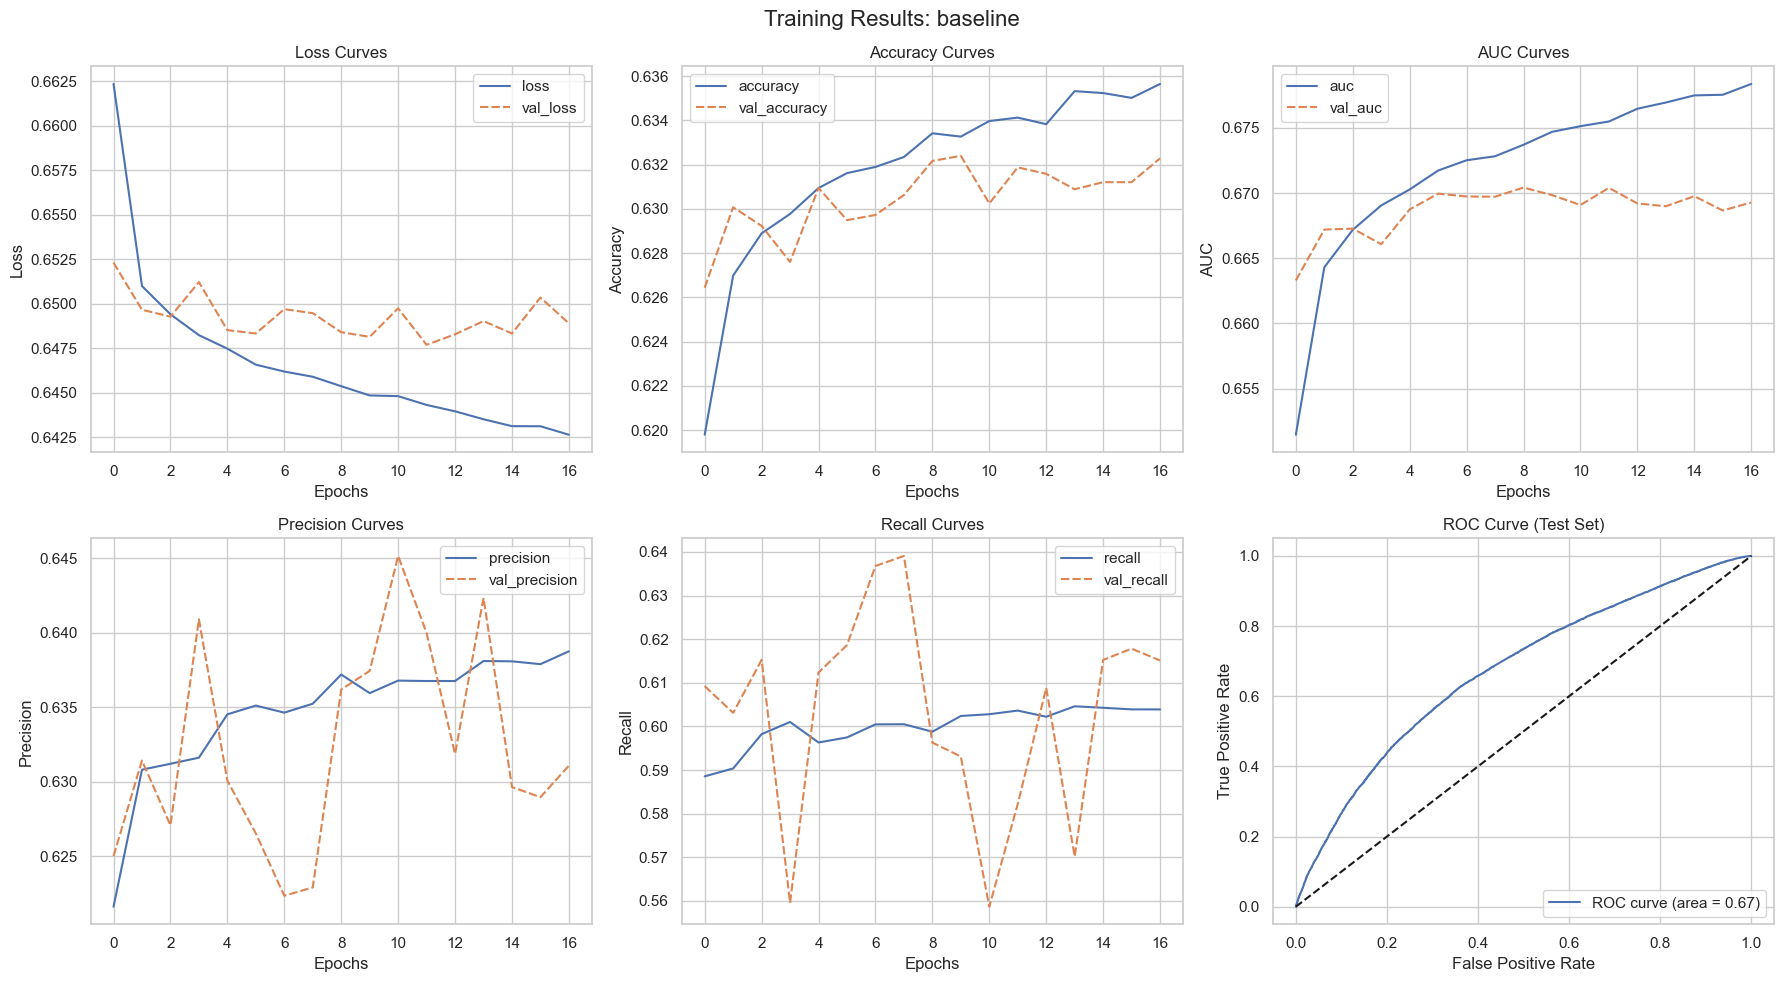


Test Metrics:
Loss: 0.6460
Accuracy: 0.6315
AUC: 0.6727
Precision: 0.6388
Recall: 0.5845
F1-Score: 0.6105

Confusion Matrix:
[[11792  5616]
 [ 7060  9933]]
baseline -> acc=0.632, auc=0.673, f1=0.610


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,953 (54.50 KB)

 Trainable params: 13,953 (54.50 KB)

 Non-trainable params: 0 (0.00 B)

Training History Summary:
        accuracy        auc       loss  precision     recall  val_accuracy  \
count  20.000000  20.000000  20.000000  20.000000  20.000000     20.000000   
mean    0.627739   0.663110   0.652787   0.632000   0.589767      0.629662   
std     0.005843   0.008442   0.007659   0.006002   0.008679      0.002062   
min     0.605125   0.631524   0.648759   0.608345   0.563160      0.622598   
25%     0.628128   0.662831   0.649548   0.631113   0.591243      0.629313   
50%     0.629142   0.665796   0.650513   0.632356   0.592139      0.629967   
75%     0.630772   0.667560   0.652250   0.635674   0.593248      0.630730   
max     0.631356   0.668821   0.683860   0.636271   0.598028      0.631842   

         val_auc   val_loss  val_precision  val_recall  
count  20.000000  20.000000      20.000000   20.000000  
mean    0.668484   0.649192       0.630374    0.605226  
std     0.002966   0.001768       0.003354    0.014504  
min     0.658681   0.647717       0.622713 

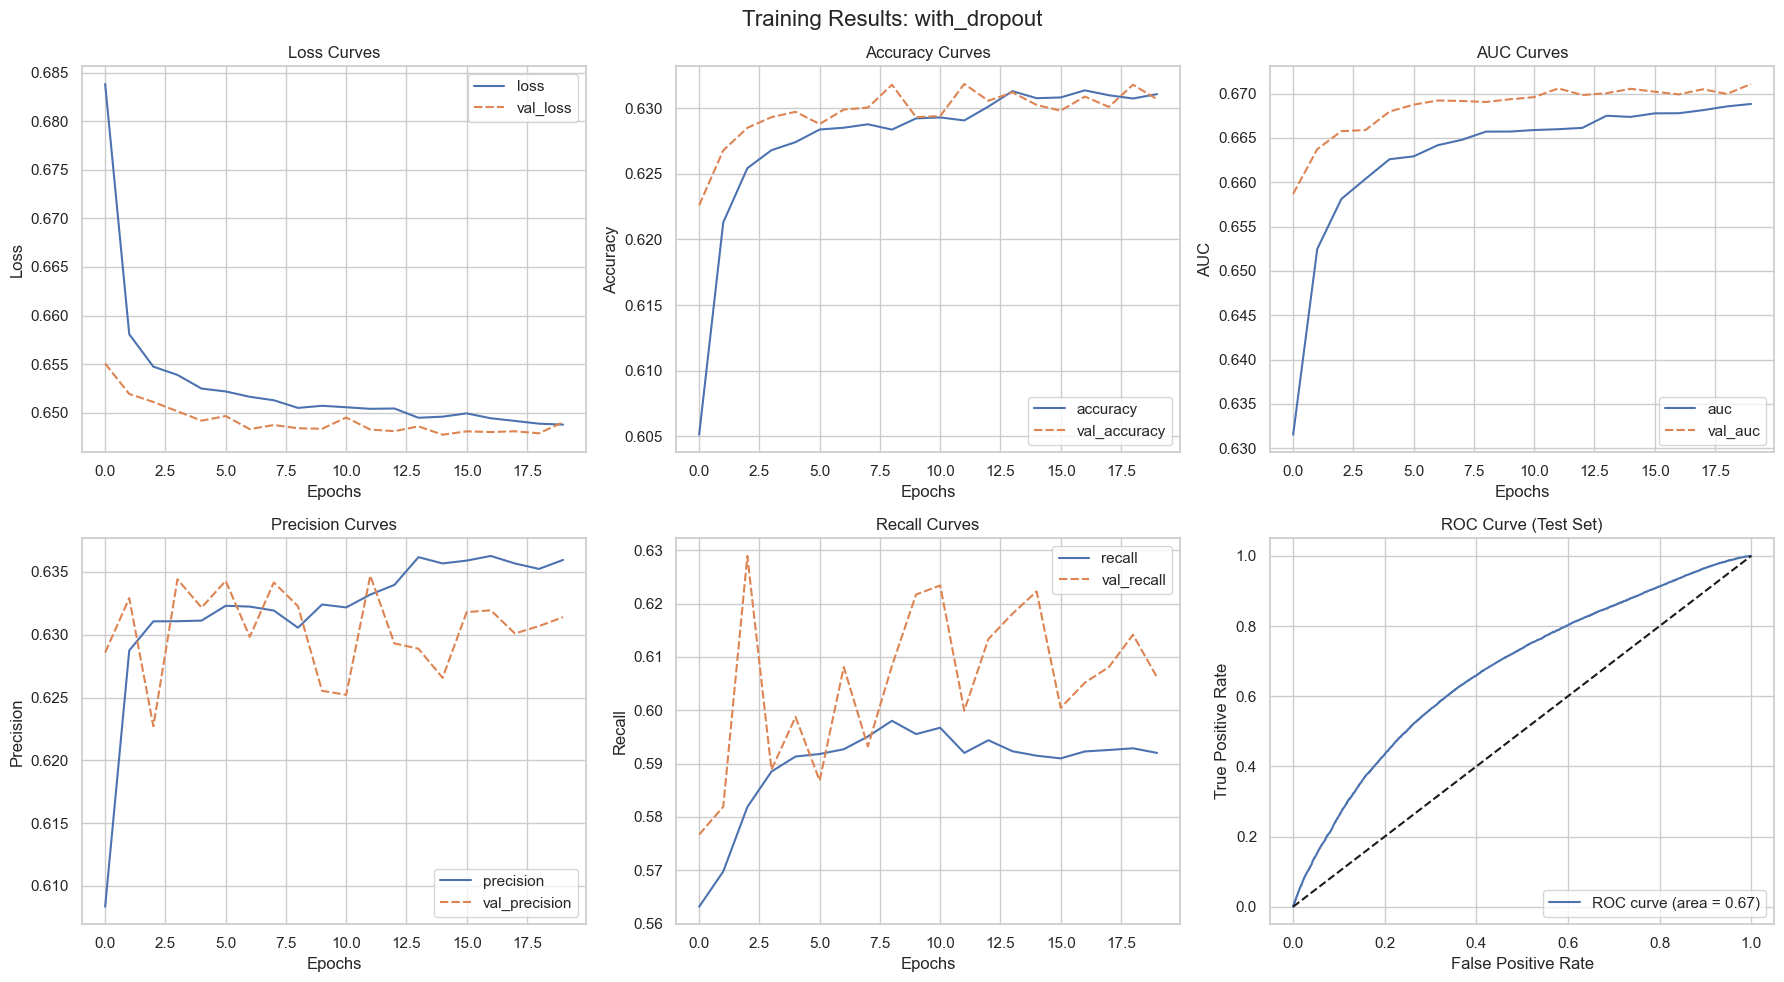


Test Metrics:
Loss: 0.6462
Accuracy: 0.6324
AUC: 0.6725
Precision: 0.6280
Recall: 0.6278
F1-Score: 0.6279

Confusion Matrix:
[[11087  6321]
 [ 6324 10669]]
with_dropout -> acc=0.632, auc=0.673, f1=0.628


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,849 (58.00 KB)

 Trainable params: 14,401 (56.25 KB)

 Non-trainable params: 448 (1.75 KB)

Training History Summary:
        accuracy        auc       loss  precision     recall  val_accuracy  \
count  22.000000  22.000000  22.000000  22.000000  22.000000     22.000000   
mean    0.626203   0.661375   0.652989   0.631037   0.585806      0.628549   
std     0.006615   0.009410   0.006897   0.007411   0.006148      0.001969   
min     0.598018   0.622279   0.649581   0.599167   0.562529      0.622802   
25%     0.626775   0.660991   0.650231   0.631491   0.584648      0.627954   
50%     0.628070   0.664211   0.650986   0.633257   0.586571      0.629124   
75%     0.628994   0.665634   0.652673   0.633974   0.589598      0.629924   
max     0.629531   0.667152   0.682699   0.634682   0.591281      0.630767   

         val_auc   val_loss  val_precision  val_recall  
count  22.000000  22.000000      22.000000   22.000000  
mean    0.666276   0.654452       0.623656    0.625824  
std     0.003016   0.003166       0.004638    0.013645  
min     0.657874   0.650027       0.611990 

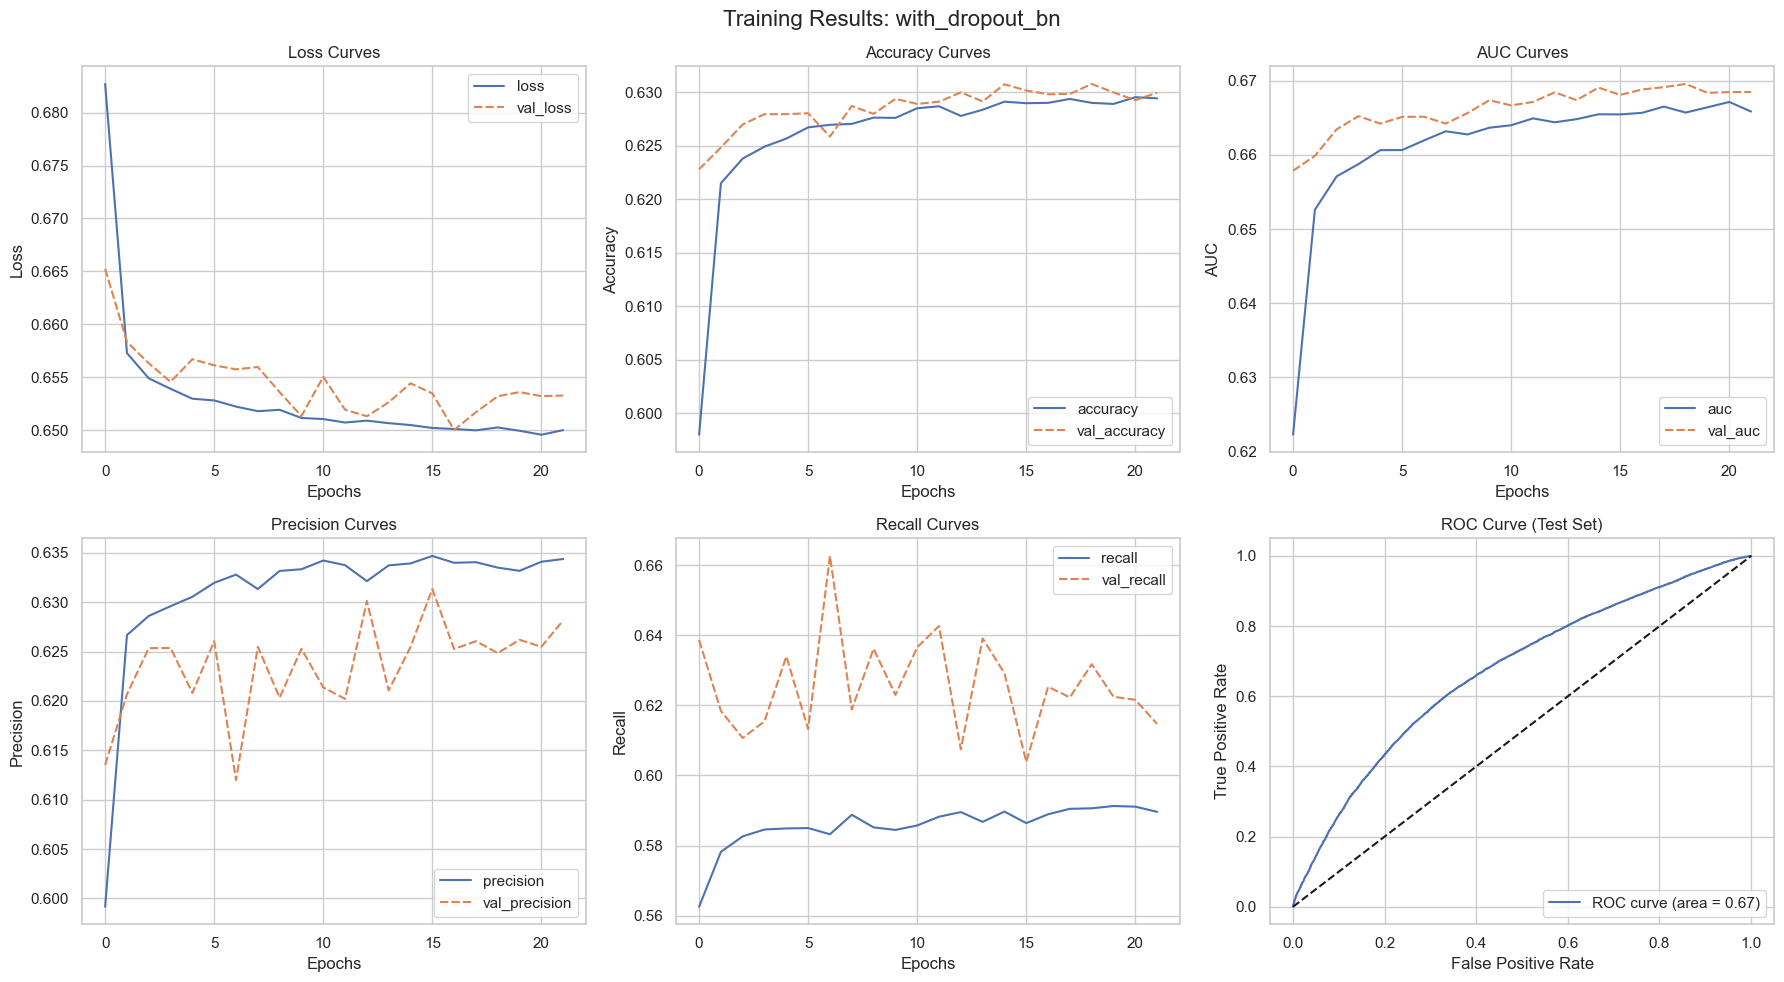


Test Metrics:
Loss: 0.6487
Accuracy: 0.6320
AUC: 0.6717
Precision: 0.6268
Recall: 0.6302
F1-Score: 0.6285

Confusion Matrix:
[[11032  6376]
 [ 6284 10709]]
with_dropout_bn -> acc=0.632, auc=0.672, f1=0.628


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,849 (58.00 KB)

 Trainable params: 14,401 (56.25 KB)

 Non-trainable params: 448 (1.75 KB)

Training History Summary:
        accuracy        auc       loss  precision     recall  val_accuracy  \
count  12.000000  12.000000  12.000000  12.000000  12.000000     12.000000   
mean    0.623873   0.657939   0.655206   0.628807   0.582550      0.626210   
std     0.007896   0.011128   0.008453   0.009510   0.004795      0.002881   
min     0.599650   0.624137   0.651180   0.599360   0.571584      0.620040   
25%     0.624699   0.658990   0.651492   0.630293   0.579550      0.626188   
50%     0.626363   0.661705   0.652401   0.631923   0.583589      0.627118   
75%     0.627558   0.663688   0.653904   0.632710   0.586552      0.628194   
max     0.628335   0.664076   0.681494   0.633523   0.587599      0.628819   

         val_auc   val_loss  val_precision  val_recall  
count  12.000000  12.000000      12.000000   12.000000  
mean    0.664250   0.656568       0.619456    0.632459  
std     0.003502   0.002133       0.007650    0.032860  
min     0.656008   0.654671       0.609430 

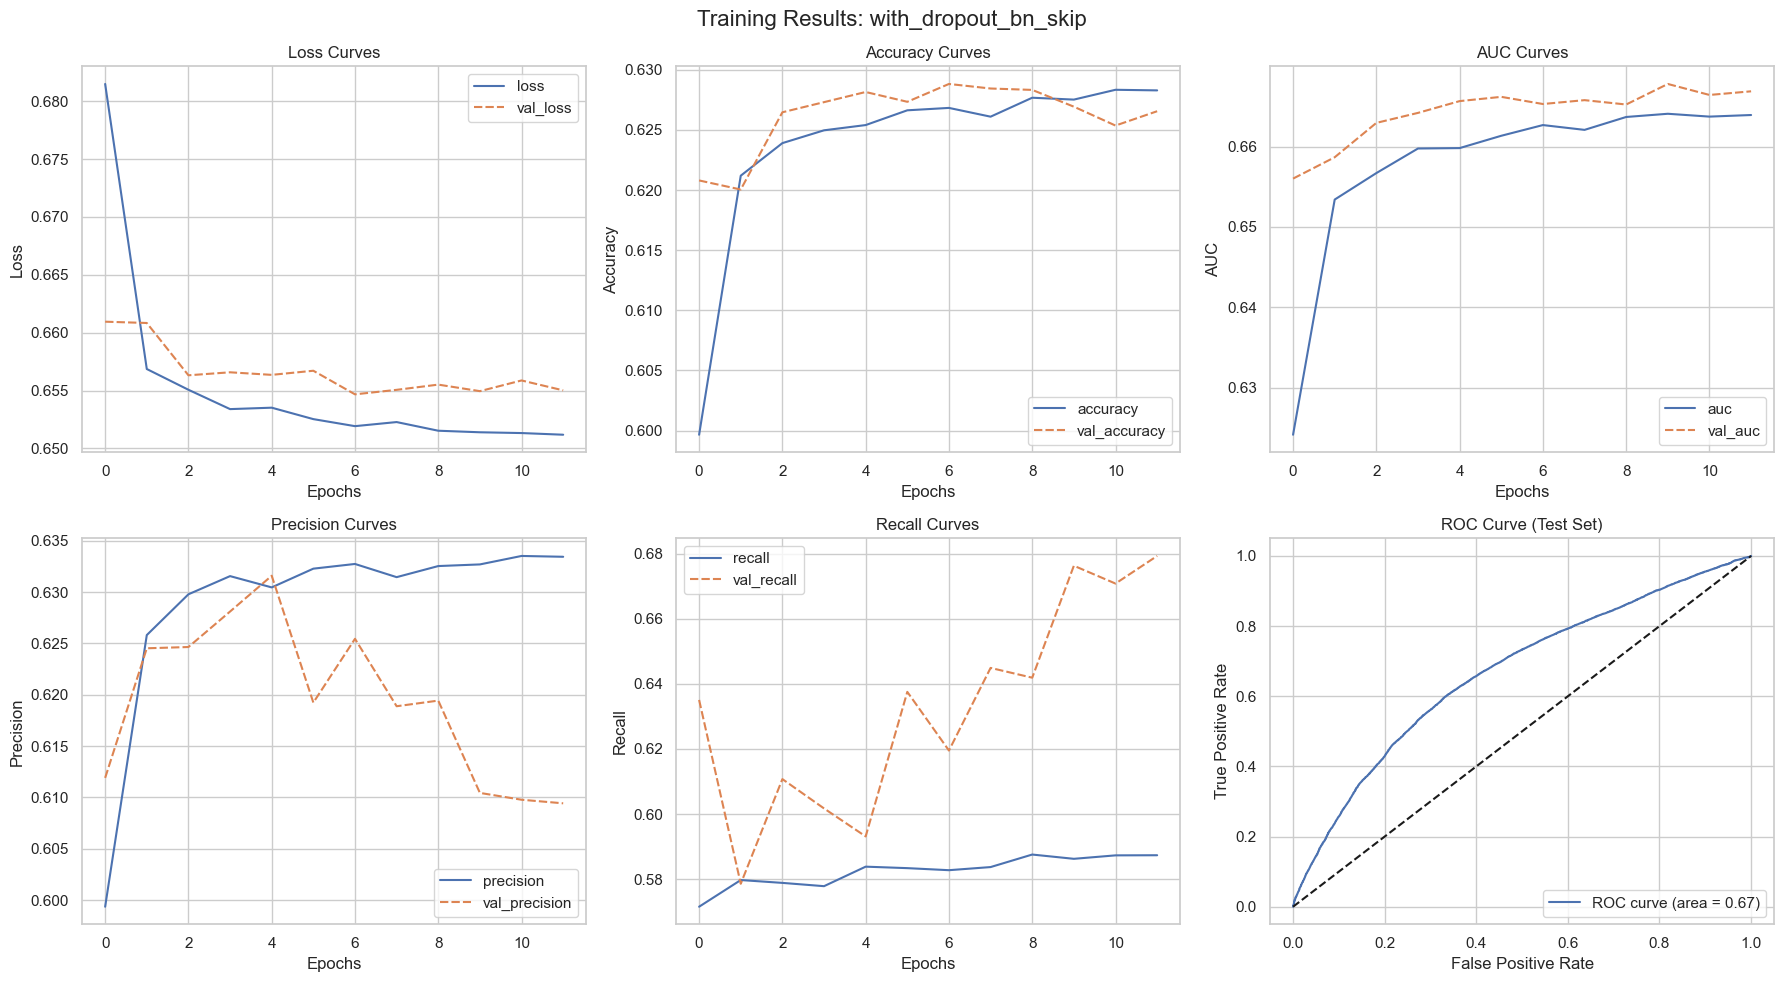


Test Metrics:
Loss: 0.6537
Accuracy: 0.6319
AUC: 0.6668
Precision: 0.6279
Recall: 0.6253
F1-Score: 0.6266

Confusion Matrix:
[[11112  6296]
 [ 6368 10625]]
with_dropout_bn_skip -> acc=0.632, auc=0.667, f1=0.627


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,361 (60.00 KB)

 Trainable params: 14,913 (58.25 KB)

 Non-trainable params: 448 (1.75 KB)

Training History Summary:
        accuracy        auc       loss  precision     recall  val_accuracy  \
count  18.000000  18.000000  18.000000  18.000000  18.000000     18.000000   
mean    0.625665   0.661031   0.652679   0.630530   0.584954      0.627814   
std     0.005770   0.008282   0.004503   0.006272   0.008323      0.002477   
min     0.604247   0.631323   0.649505   0.606123   0.567775      0.622191   
25%     0.625658   0.660912   0.650519   0.631166   0.581454      0.626007   
50%     0.627491   0.663768   0.651220   0.632052   0.588015      0.628790   
75%     0.627866   0.664993   0.652781   0.632508   0.589525      0.629676   
max     0.629817   0.666960   0.668929   0.634376   0.595695      0.630447   

         val_auc   val_loss  val_precision  val_recall  
count  18.000000  18.000000      18.000000   18.000000  
mean    0.665801   0.653340       0.631413    0.592782  
std     0.003001   0.002176       0.004697    0.021997  
min     0.658787   0.649630       0.623167 

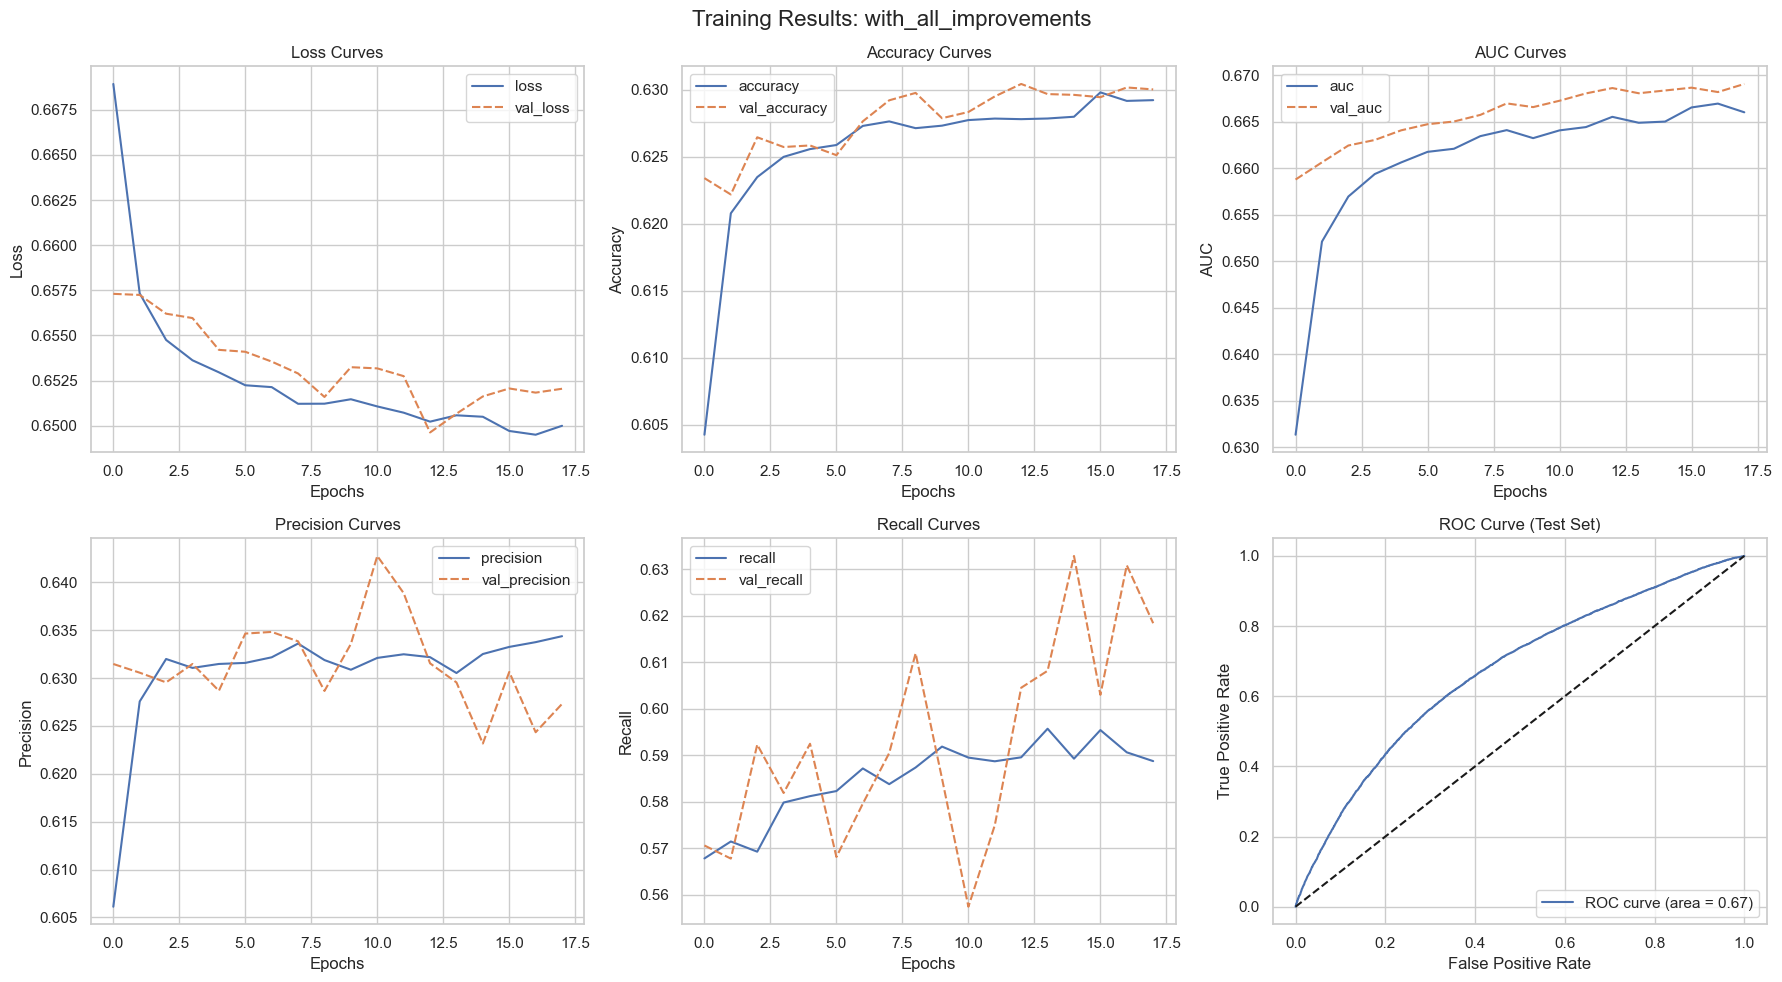


Test Metrics:
Loss: 0.6480
Accuracy: 0.6326
AUC: 0.6715
Precision: 0.6334
Recall: 0.6083
F1-Score: 0.6206

Confusion Matrix:
[[11424  5984]
 [ 6656 10337]]
with_all_improvements -> acc=0.633, auc=0.672, f1=0.621


(<Functional name=functional_4, built=True>,
 {'loss': 0.6479520797729492,
  'accuracy': 0.6325688362121582,
  'auc': 0.6715261936187744,
  'precision': 0.6333557963371277,
  'recall': 0.6083093285560608,
  'f1': np.float64(0.6205799363630906)})

In [50]:
# Baseline
config["model"].update({
    "dropout_rate": 0,
    "batch_norm": False,
    "skip_connection": False,
    "bottleneck": False
})
config["experiment"]["name"] = "baseline"
config["experiment"]["description"] = "Baseline without improvements"
baseline_model, baseline_metrics = run_experiment(config, class_weight=class_weight_dict)

# Dropout
config["model"].update({
    "dropout_rate": 0.3
})
config["experiment"]["name"] = "with_dropout"
config["experiment"]["description"] = "Added dropout for regularization"
run_experiment(config, class_weight=class_weight_dict)

# BN
config["model"].update({
    "batch_norm": True
})
config["experiment"]["name"] = "with_dropout_bn"
config["experiment"]["description"] = "Added BN to stabilize training"
run_experiment(config, class_weight=class_weight_dict)

# Skip
config["model"].update({
    "skip_connection": True
})
config["experiment"]["name"] = "with_dropout_bn_skip"
config["experiment"]["description"] = "Added skip connections for gradient flow"
run_experiment(config, class_weight=class_weight_dict)

# Full improvements
config["model"].update({
    "bottleneck": True
})
config["experiment"]["name"] = "with_all_improvements"
config["experiment"]["description"] = "Full improvements including bottleneck"
run_experiment(config, class_weight=class_weight_dict)

###  Experiment Results Summary

After running multiple experiments, we noticed that the best-performing model was the one named **`with_all_improvements`**.  
This model included batch normalization, dropout, and the bottleneck layer, and it achieved the highest performance on the validation set.

We also observed that the models that used **batch normalization and dropout** consistently performed better than those without them.  
This means that these two techniques have the **strongest positive impact on the final results**, as they help the network generalize better and avoid overfitting.



## Hyperparameter search (grid/random) / sweep

### Hyperparameter Search with `ParameterSampler`

This block is used to test different MLP configurations and find a more effective model architecture.  
Instead of manually changing parameters every time, we generate multiple random combinations using `ParameterSampler`.

This method is more efficient than a full grid search because it allows us to explore many different setups without testing every possible combination.

---

**Parameters that are being randomly tested:**
- `dropout_rate` – amount of dropout for regularization  
- `batch_norm` – whether Batch Normalization is used  
- `bottleneck` – adds a dense bottleneck layer before the output  
- `skip_connection` – enables residual connections between layers  
- `hidden_layers` – different network depths and layer sizes  
- `learning_rate`, `batch_size`, `epochs` – training hyperparameters

---

**For each randomly generated configuration:**
1. The model and training parameters are updated inside `config`  
2. A unique experiment name is assigned (`random_i`)  
3. `run_experiment()` trains the model, evaluates it and logs results to W&B

---

This approach helps us understand which components (dropout, batch norm, bottleneck, etc.) actually improve performance and which ones do not have a significant effect.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,385 (189.00 KB)

 Trainable params: 48,385 (189.00 KB)

 Non-trainable params: 0 (0.00 B)

Training History Summary:
        accuracy        auc       loss  precision     recall  val_accuracy  \
count  29.000000  29.000000  29.000000  29.000000  29.000000     29.000000   
mean    0.628882   0.665039   0.651493   0.632524   0.593513      0.630141   
std     0.004988   0.007482   0.007036   0.005485   0.006235      0.001842   
min     0.606440   0.632311   0.647956   0.608641   0.569351      0.622627   
25%     0.629082   0.664718   0.648774   0.631986   0.593009      0.629836   
50%     0.630471   0.667263   0.649614   0.634514   0.594610      0.630621   
75%     0.631082   0.668660   0.651281   0.635668   0.596678      0.631115   
max     0.632359   0.670169   0.685994   0.636836   0.600323      0.631987   

         val_auc   val_loss  val_precision  val_recall  
count  29.000000  29.000000      29.000000   29.000000  
mean    0.668458   0.649096       0.632227    0.601106  
std     0.002514   0.001507       0.004827    0.017310  
min     0.657533   0.647617       0.619072 

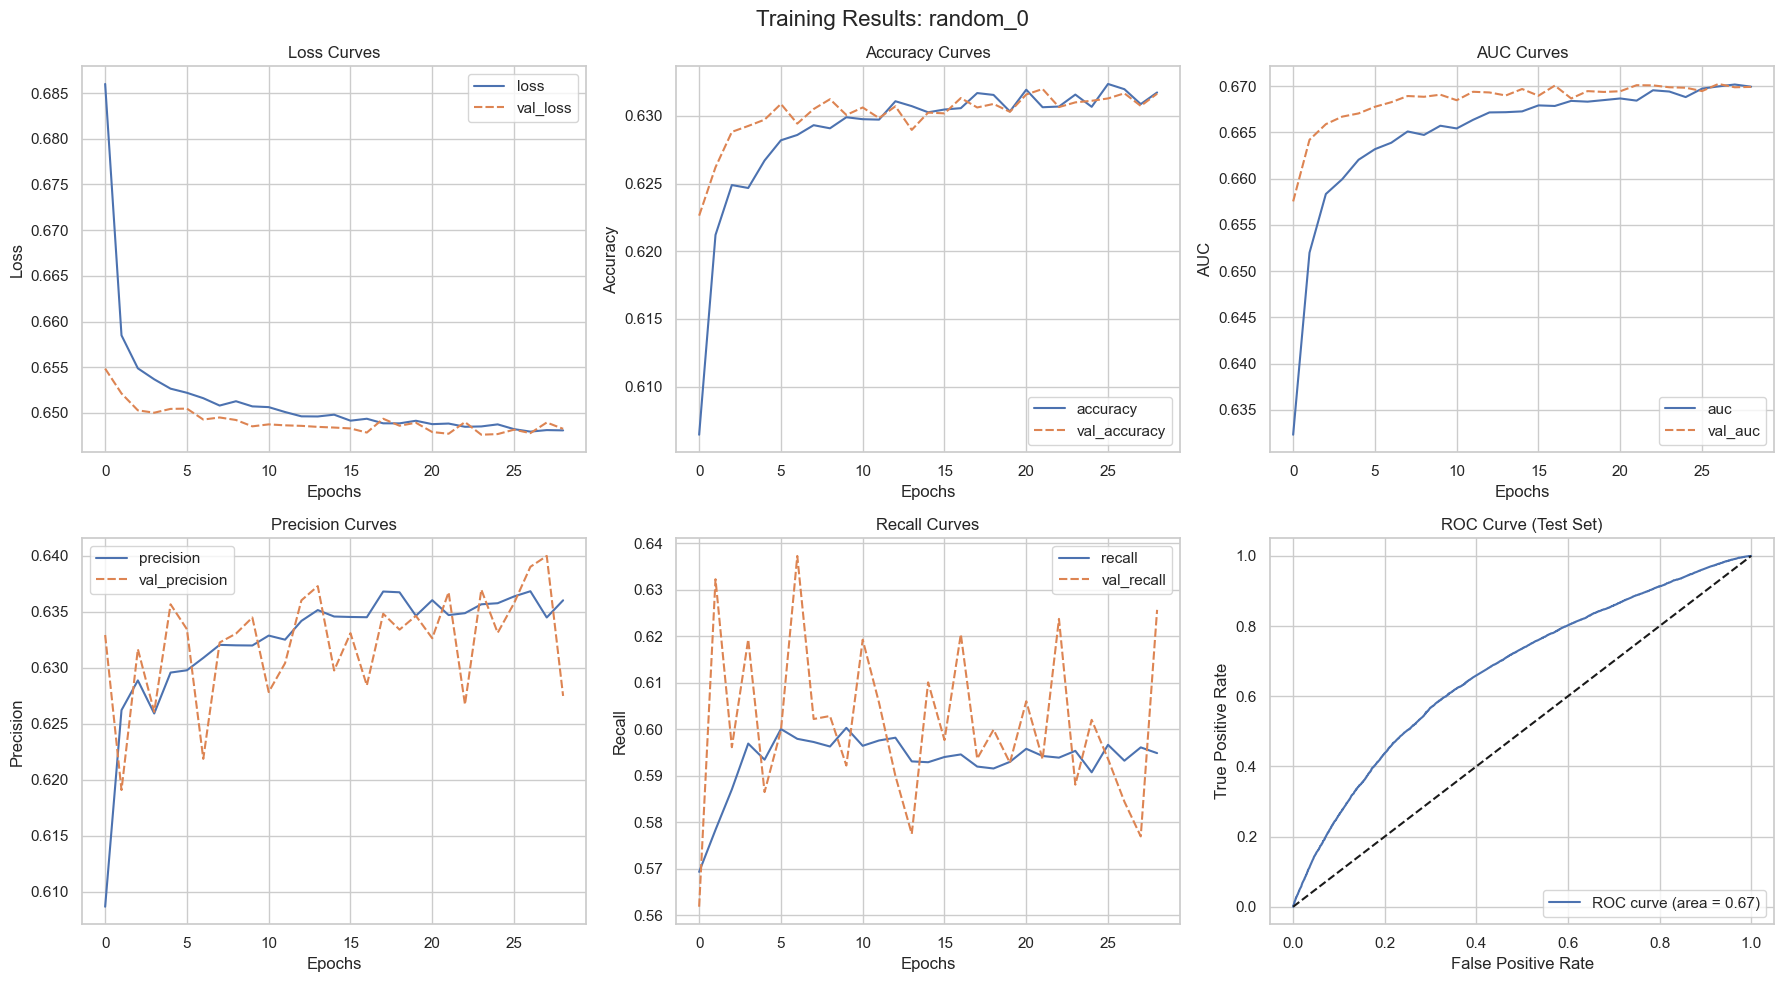


Test Metrics:
Loss: 0.6460
Accuracy: 0.6343
AUC: 0.6725
Precision: 0.6400
Recall: 0.5937
F1-Score: 0.6160

Confusion Matrix:
[[11734  5674]
 [ 6905 10088]]
random_0 -> acc=0.634, auc=0.673, f1=0.616


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 192 (768.00 B)

Training History Summary:
        accuracy        auc       loss  precision     recall  val_accuracy  \
count  21.000000  21.000000  21.000000  21.000000  21.000000     21.000000   
mean    0.625926   0.662774   0.652500   0.629795   0.589112      0.627116   
std     0.008716   0.012188   0.009554   0.010123   0.006435      0.003520   
min     0.590194   0.614382   0.648108   0.587898   0.569742      0.618151   
25%     0.627170   0.663863   0.648713   0.631349   0.586678      0.626377   
50%     0.628322   0.667031   0.649539   0.632781   0.591533      0.628586   
75%     0.629450   0.668366   0.651177   0.633374   0.593135      0.629226   
max     0.631101   0.669302   0.692166   0.635208   0.595594      0.630127   

         val_auc   val_loss  val_precision  val_recall  
count  21.000000  21.000000      21.000000   21.000000  
mean    0.664401   0.654763       0.628250    0.600445  
std     0.005587   0.003702       0.003157    0.017277  
min     0.647749   0.651186       0.620125 

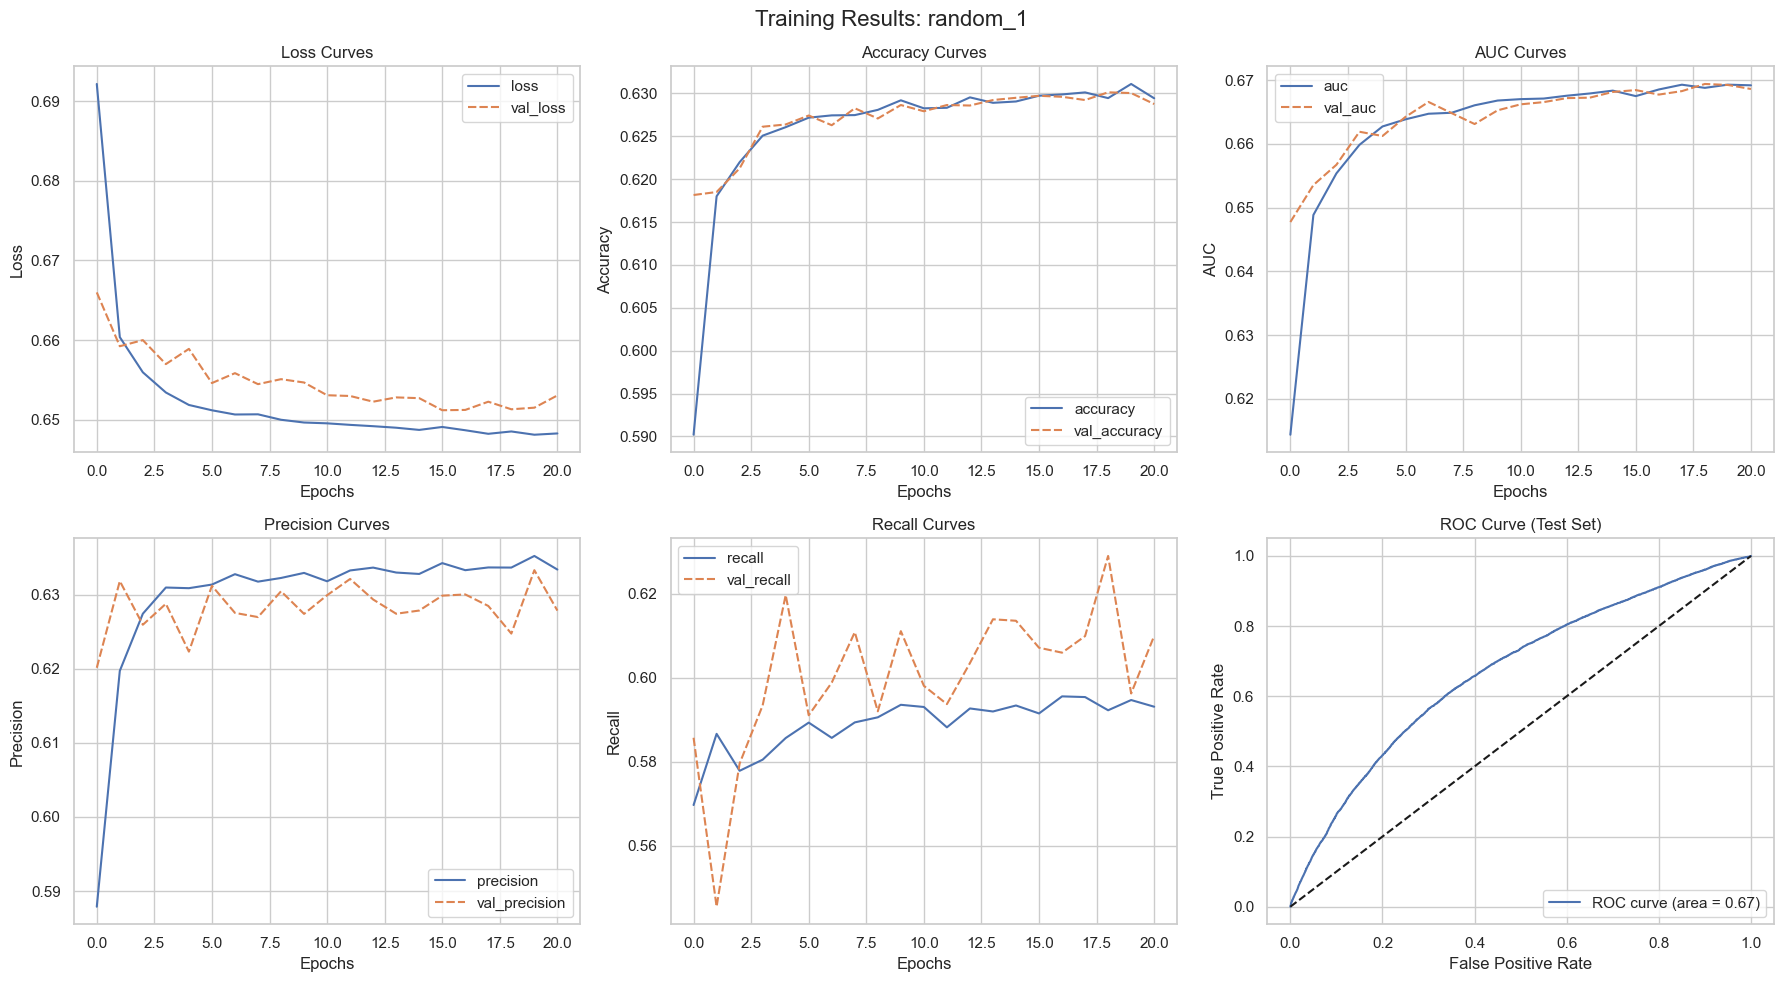


Test Metrics:
Loss: 0.6501
Accuracy: 0.6326
AUC: 0.6711
Precision: 0.6321
Recall: 0.6131
F1-Score: 0.6225

Confusion Matrix:
[[11344  6064]
 [ 6574 10419]]
random_1 -> acc=0.633, auc=0.671, f1=0.622


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 192 (768.00 B)

Training History Summary:
        accuracy        auc       loss  precision     recall  val_accuracy  \
count  50.000000  50.000000  50.000000  50.000000  50.000000     50.000000   
mean    0.614386   0.643593   0.662330   0.618107   0.580608      0.618906   
std     0.021397   0.026202   0.017443   0.024343   0.026080      0.017383   
min     0.509907   0.515551   0.653532   0.502621   0.540133      0.512340   
25%     0.616238   0.643201   0.654865   0.618023   0.577867      0.621130   
50%     0.622399   0.652550   0.656896   0.627517   0.579522      0.623528   
75%     0.624348   0.656462   0.661679   0.630628   0.580663      0.624509   
max     0.626410   0.659037   0.763107   0.632632   0.750766      0.625883   

         val_auc   val_loss  val_precision  val_recall  
count  50.000000  50.000000      50.000000   50.000000  
mean    0.656304   0.658778       0.614852    0.625033  
std     0.010151   0.008282       0.021306    0.057710  
min     0.599509   0.653886       0.503356 

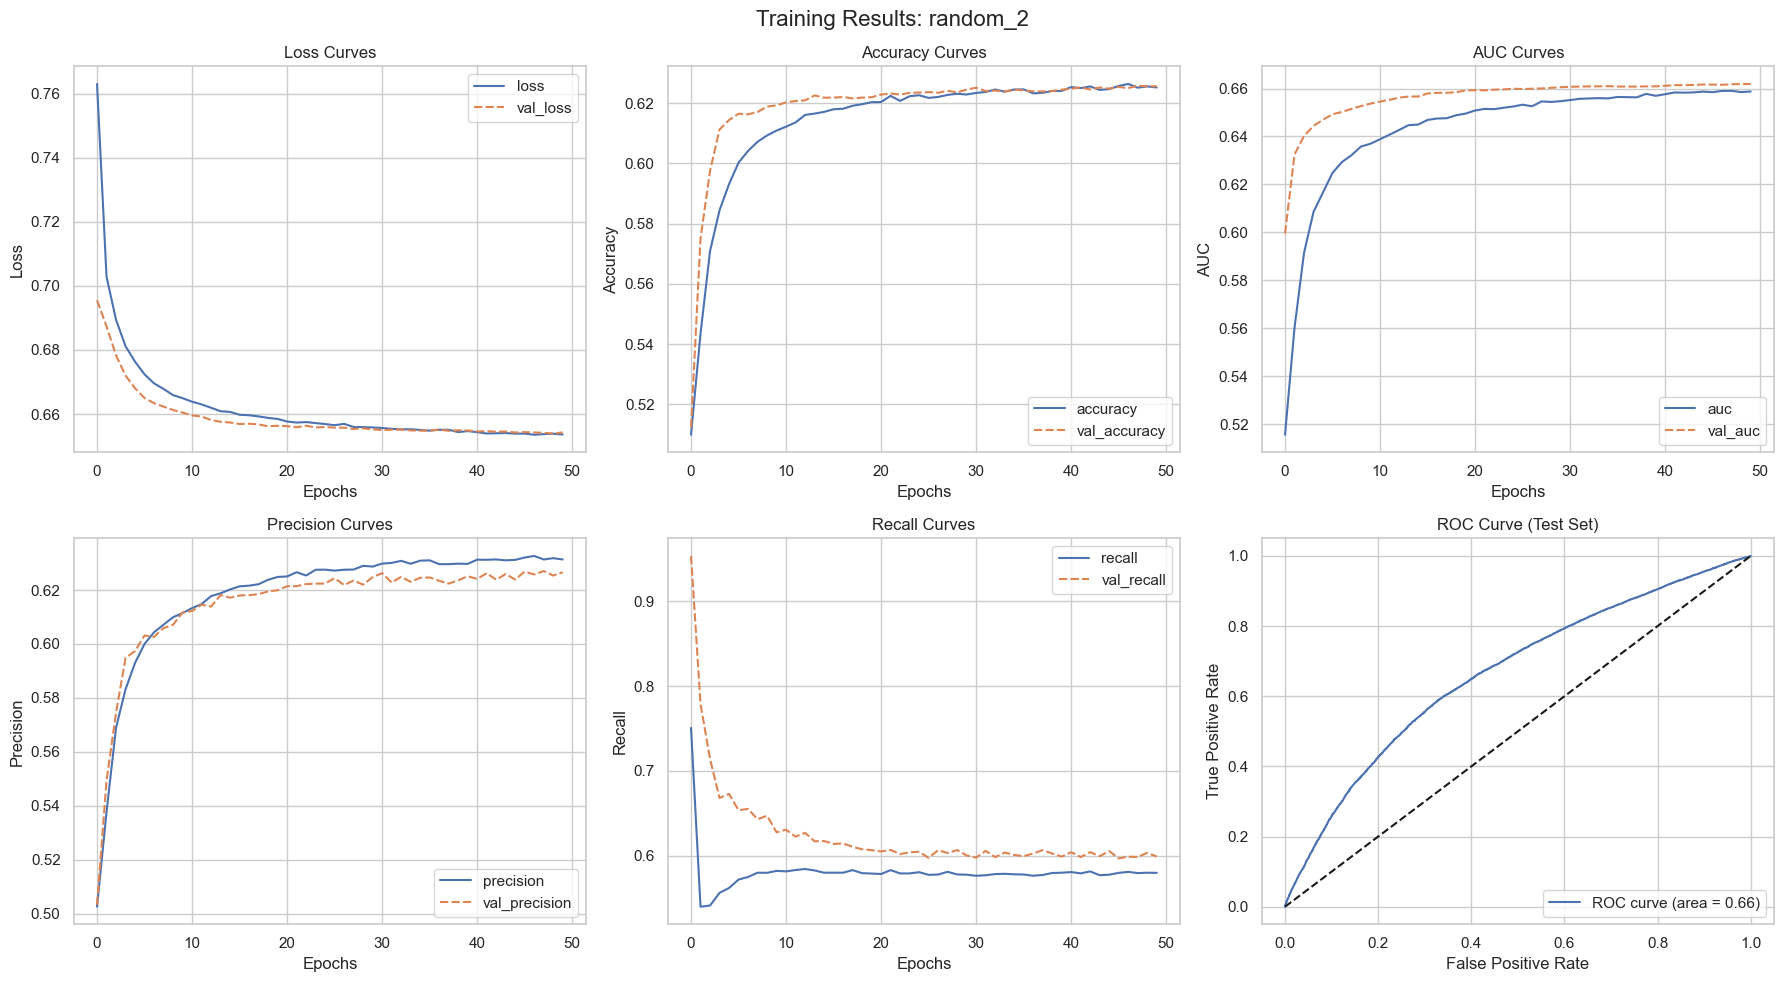


Test Metrics:
Loss: 0.6525
Accuracy: 0.6282
AUC: 0.6646
Precision: 0.6273
Recall: 0.6094
F1-Score: 0.6182

Confusion Matrix:
[[11255  6153]
 [ 6637 10356]]
random_2 -> acc=0.628, auc=0.665, f1=0.618


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 192 (768.00 B)

Training History Summary:
        accuracy        auc       loss  precision     recall  val_accuracy  \
count  50.000000  50.000000  50.000000  50.000000  50.000000     50.000000   
mean    0.629314   0.667862   0.648895   0.632655   0.595095      0.628308   
std     0.004720   0.007004   0.003992   0.004868   0.006689      0.002655   
min     0.602553   0.631384   0.646069   0.602814   0.572756      0.619313   
25%     0.628947   0.666872   0.646630   0.632037   0.594743      0.628041   
50%     0.631013   0.670314   0.647523   0.634150   0.597511      0.629022   
75%     0.631655   0.671790   0.649365   0.634838   0.598825      0.629902   
max     0.632639   0.673022   0.670419   0.635638   0.600689      0.631639   

         val_auc   val_loss  val_precision  val_recall  
count  50.000000  50.000000      50.000000   50.000000  
mean    0.667729   0.650011       0.626905    0.611581  
std     0.004146   0.002716       0.003547    0.015416  
min     0.653269   0.647324       0.617222 

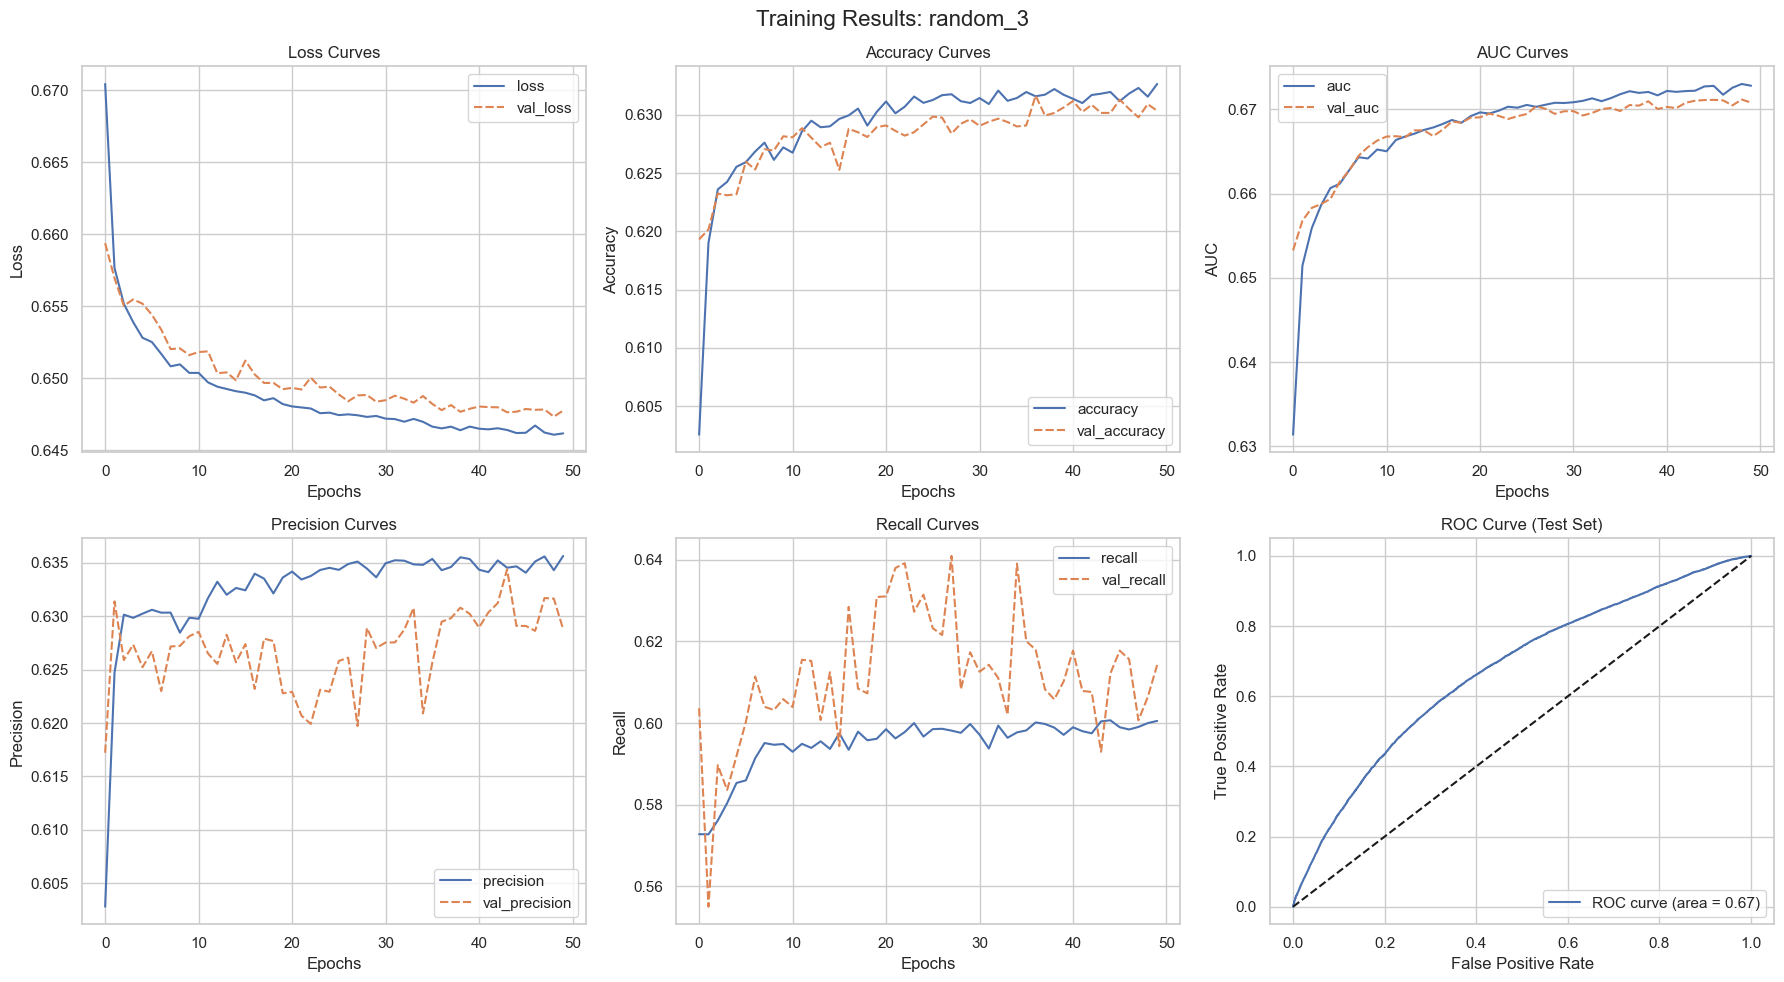


Test Metrics:
Loss: 0.6454
Accuracy: 0.6326
AUC: 0.6742
Precision: 0.6325
Recall: 0.6117
F1-Score: 0.6219

Confusion Matrix:
[[11369  6039]
 [ 6599 10394]]
random_3 -> acc=0.633, auc=0.674, f1=0.622


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 64)                  │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 192 (768.00 B)

Training History Summary:
        accuracy        auc       loss  precision     recall  val_accuracy  \
count  20.000000  20.000000  20.000000  20.000000  20.000000     20.000000   
mean    0.626086   0.662792   0.651694   0.629857   0.589563      0.626579   
std     0.007900   0.010406   0.005495   0.009091   0.005863      0.003443   
min     0.595514   0.624177   0.647800   0.594732   0.568595      0.617889   
25%     0.625568   0.661562   0.648580   0.629186   0.588740      0.626050   
50%     0.628768   0.666290   0.649778   0.632563   0.591426      0.627554   
75%     0.630180   0.668614   0.652365   0.634722   0.592678      0.628942   
max     0.631082   0.670290   0.672038   0.635914   0.594699      0.629807   

         val_auc   val_loss  val_precision  val_recall  
count  20.000000  20.000000      20.000000   20.000000  
mean    0.665028   0.652290       0.630988    0.588939  
std     0.004099   0.002951       0.005733    0.034396  
min     0.654541   0.649471       0.622165 

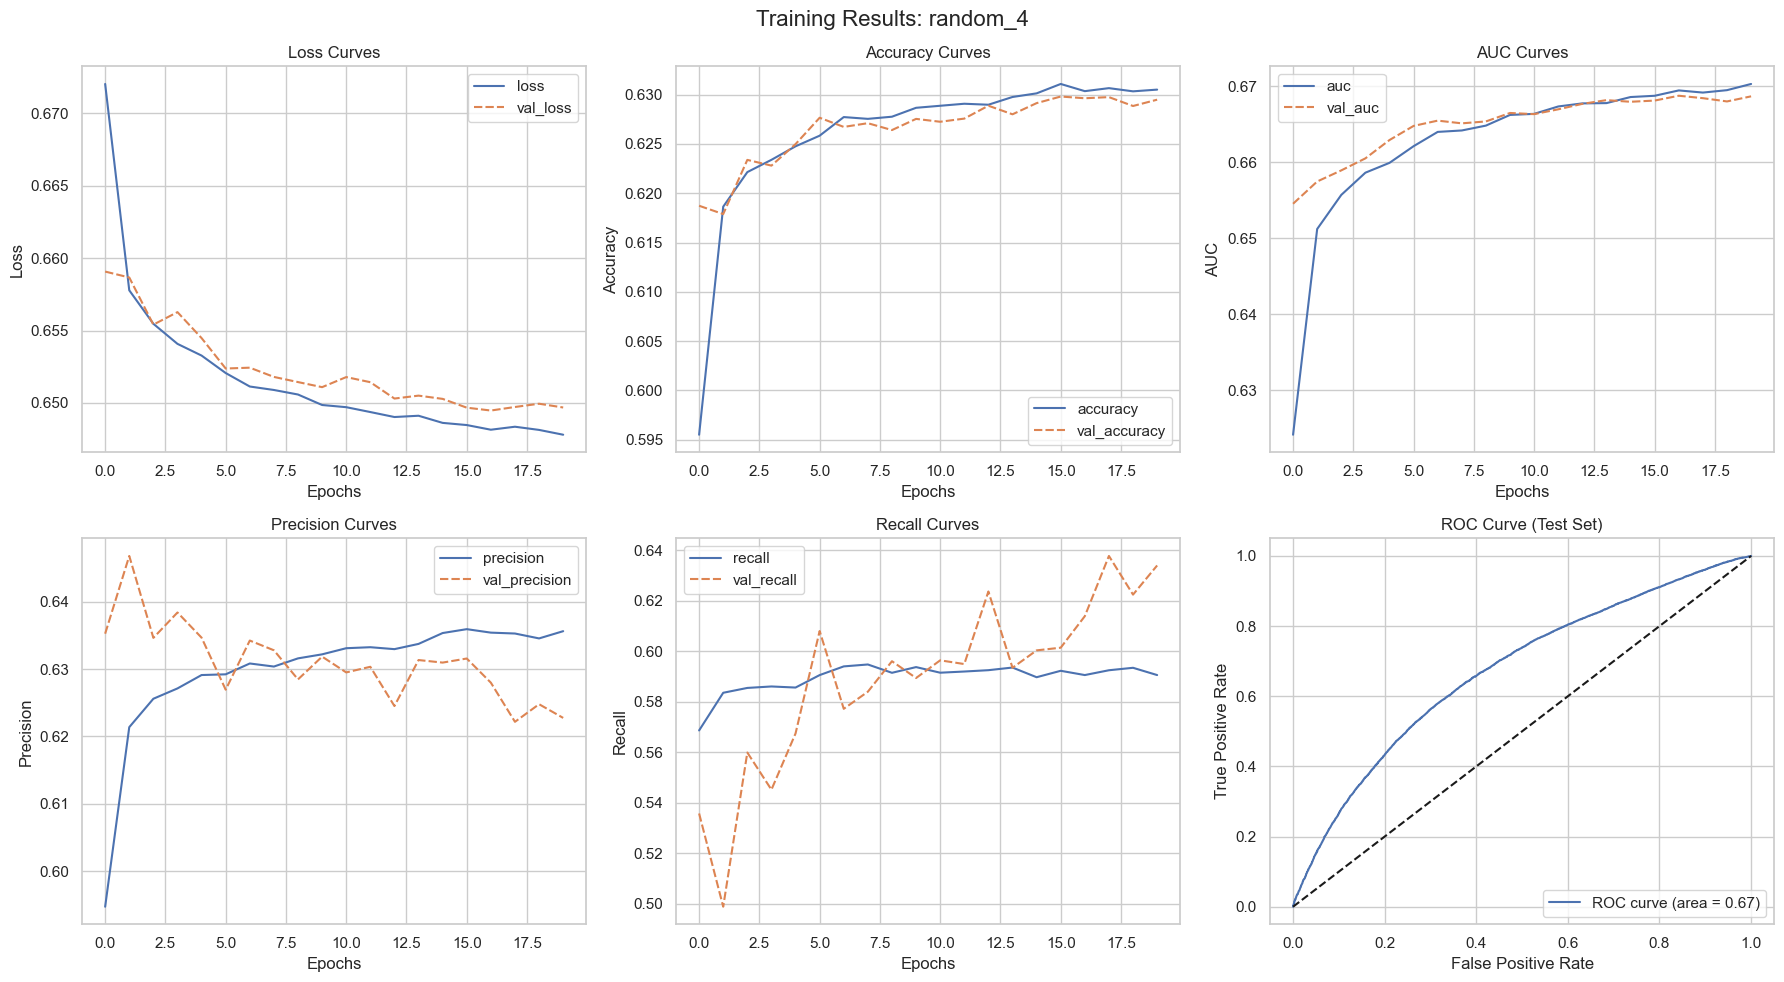


Test Metrics:
Loss: 0.6478
Accuracy: 0.6313
AUC: 0.6721
Precision: 0.6292
Recall: 0.6178
F1-Score: 0.6234

Confusion Matrix:
[[11221  6187]
 [ 6495 10498]]
random_4 -> acc=0.631, auc=0.672, f1=0.623


In [51]:
from sklearn.model_selection import ParameterSampler

param_dist = {
    "dropout_rate": [0.1, 0.2, 0.3, 0.4, 0.5],
    "batch_norm": [True, False],
    "bottleneck": [True, False],
    "skip_connection": [True, False],
    "hidden_layers": [[128, 64, 32], [256, 128, 64], [64, 32]],
    "learning_rate": [0.001, 0.0005, 0.0001],
    "batch_size": [32, 64, 128],
    "epochs": [20, 30, 50]
}

random_params = list(ParameterSampler(param_dist, n_iter=5, random_state=42))

for i, params in enumerate(random_params):
    config["model"].update({
        "dropout_rate": params["dropout_rate"],
        "batch_norm": params["batch_norm"],
        "bottleneck": params["bottleneck"],
        "skip_connection": params["skip_connection"],
        "hidden_layers": params["hidden_layers"]
    })
    config["training"].update({
        "learning_rate": params["learning_rate"],
        "batch_size": params["batch_size"],
        "epochs": params["epochs"]
    })

    config["experiment"]["name"] = f"random_{i}"
    config["experiment"]["description"] = "Random search with ParameterSampler"

    run_experiment(config, class_weight=class_weight_dict)


## Results and evaluation metrics and Best Model Selection

This section is focused on analysing all saved experiments, selecting the best-performing model and checking whether it overfits.

---

#### 1. Loading and ranking experiment logs
- All past experiment results are loaded from `experiments_log.json`.
- The results are converted into a pandas DataFrame.
- Experiments are sorted by F1-score (descending), since F1 is a balanced metric for classification.

---

#### 2. Visual comparison of top configurations
- The **Top 10 experiments** are visualized using a bar chart (F1 score on the y-axis).
- Bars are colored based on whether **Batch Normalization was used**, to show its impact.
- A **correlation heatmap** is plotted to show how metrics (accuracy, AUC, F1) relate to configuration choices (dropout, batch_norm, bottleneck, skip connections).

---

#### 3. Selecting and retraining the best model
- The configuration with the highest F1 score is identified.
- The model is re-trained using this best config and re-evaluated on the test dataset.
- A **confusion matrix** is generated to show how well the model predicts each class.

---

#### 4. Overfitting analysis
- Loss and accuracy are evaluated on **train, validation, and test sets**.
- Results are displayed in a grouped bar plot.
- If validation/test loss is significantly higher than train loss (e.g. >20%), a warning is printed about potential overfitting.

---

#### 5. Class-wise percentage performance
To give a clearer interpretation of the confusion matrix (as suggested by the instructor), we can also compute:
- **Per-class accuracy / recall (%)**
- **Percentage of correctly classified samples per class**
- Example:  
  - Class 0 → 87% predicted correctly  
  - Class 1 → 91% predicted correctly  

This helps to interpret not just the confusion matrix values, but how well the model performs in percentage terms.

---

This evaluation pipeline allows us to:
- Compare experiments objectively,
- Identify which settings improve the model (BatchNorm, Dropout, etc.),
- Select and re-train the best-performing model,
- Check for overfitting,
- And finally present class-wise performance in both counts and percentages.


Top 10 Experiments:
                  time                   name  accuracy       auc        f1  \
0  2025-11-08 10:31:35  with_all_improvements  0.629662  0.669920  0.631622   
1  2025-11-08 10:30:16        with_dropout_bn  0.630708  0.671260  0.630848   
2  2025-11-10 11:18:20        with_dropout_bn  0.631987  0.671717  0.628499   
3  2025-11-10 11:13:56           with_dropout  0.632423  0.672503  0.627902   
4  2025-11-07 20:37:36           with_dropout  0.631522  0.671450  0.627615   
5  2025-11-07 20:40:07               random_0  0.632278  0.671768  0.627569   
6  2025-11-07 20:40:24               random_1  0.629226  0.666959  0.627014   
7  2025-11-10 11:20:20   with_dropout_bn_skip  0.631871  0.666845  0.626585   
8  2025-11-07 20:41:41               random_3  0.632918  0.674217  0.625148   
9  2025-11-08 10:34:34  with_all_improvements  0.631639  0.671186  0.624578   

   dropout   skip     bn  bottleneck  
0      0.3   True   True        True  
1      0.3  False   True       F

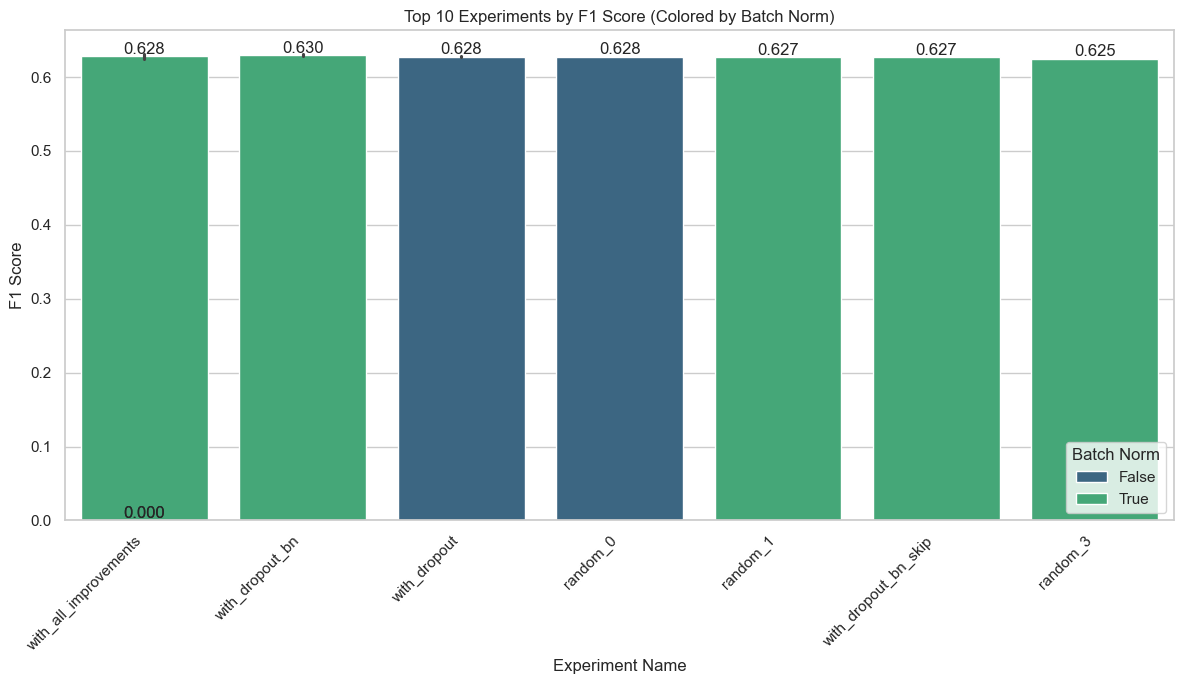

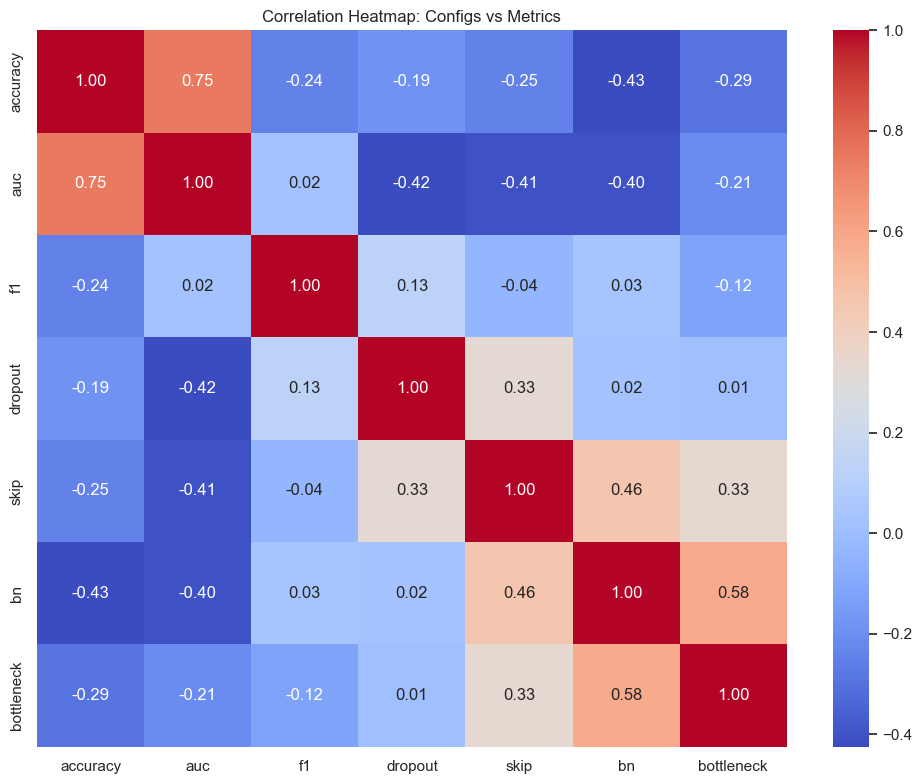

Best experiment: with_all_improvements with F1=0.632


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,361 (60.00 KB)

 Trainable params: 14,913 (58.25 KB)

 Non-trainable params: 448 (1.75 KB)

Training History Summary:
        accuracy        auc       loss  precision     recall  val_accuracy  \
count  17.000000  17.000000  17.000000  17.000000  17.000000     17.000000   
mean    0.624965   0.660156   0.653246   0.630506   0.581814      0.627128   
std     0.007474   0.010366   0.006010   0.008883   0.006453      0.003299   
min     0.597252   0.623740   0.649703   0.597103   0.567737      0.619575   
25%     0.625476   0.659352   0.650246   0.631122   0.577990      0.626028   
50%     0.627151   0.663720   0.651242   0.633268   0.583160      0.628208   
75%     0.628160   0.665576   0.653490   0.633973   0.588217      0.629255   
max     0.629101   0.666419   0.674812   0.636027   0.589881      0.631551   

         val_auc   val_loss  val_precision  val_recall  
count  17.000000  17.000000      17.000000   17.000000  
mean    0.665228   0.655449       0.618240    0.642136  
std     0.003738   0.002885       0.007607    0.023284  
min     0.655741   0.651148       0.604462 

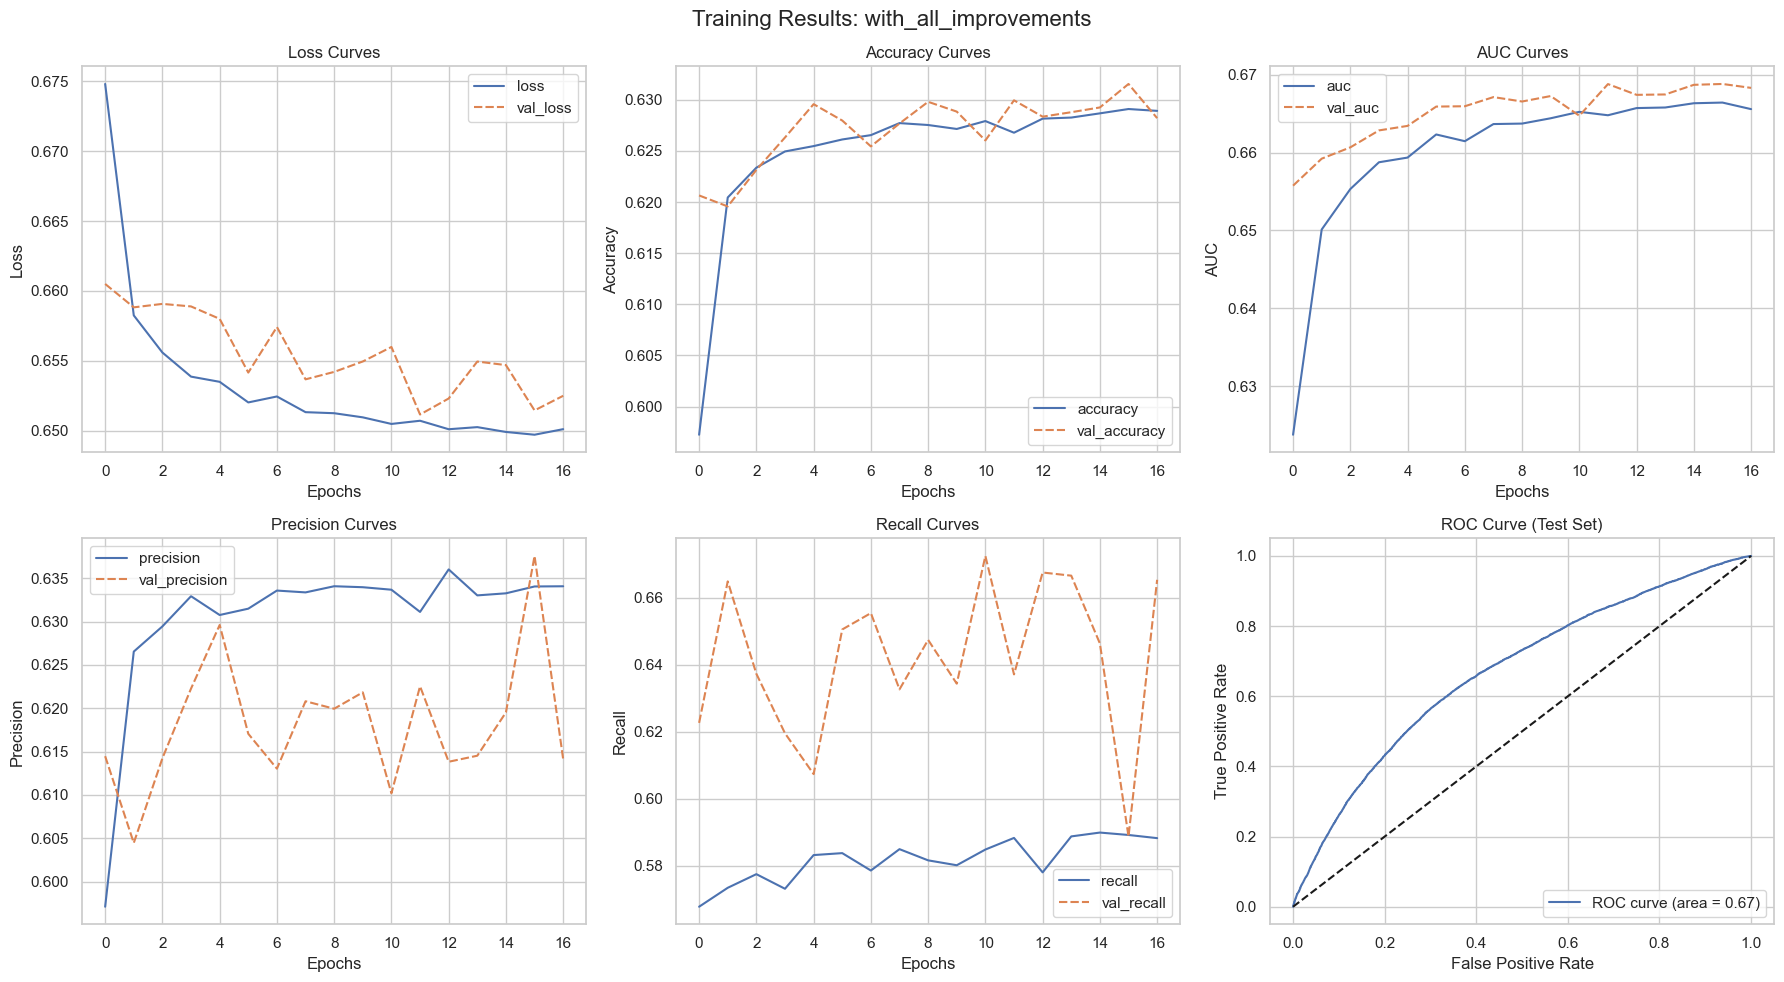


Test Metrics:
Loss: 0.6503
Accuracy: 0.6311
AUC: 0.6709
Precision: 0.6236
Recall: 0.6386
F1-Score: 0.6310

Confusion Matrix:
[[10857  6551]
 [ 6141 10852]]
with_all_improvements -> acc=0.631, auc=0.671, f1=0.631


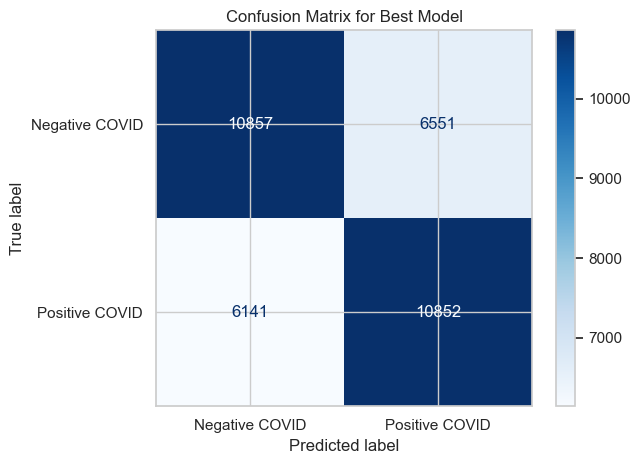

Overfitting check:
     Set      Loss  Accuracy
0  Train  0.650590  0.630341
1    Val  0.651149  0.629953
2   Test  0.650273  0.631057


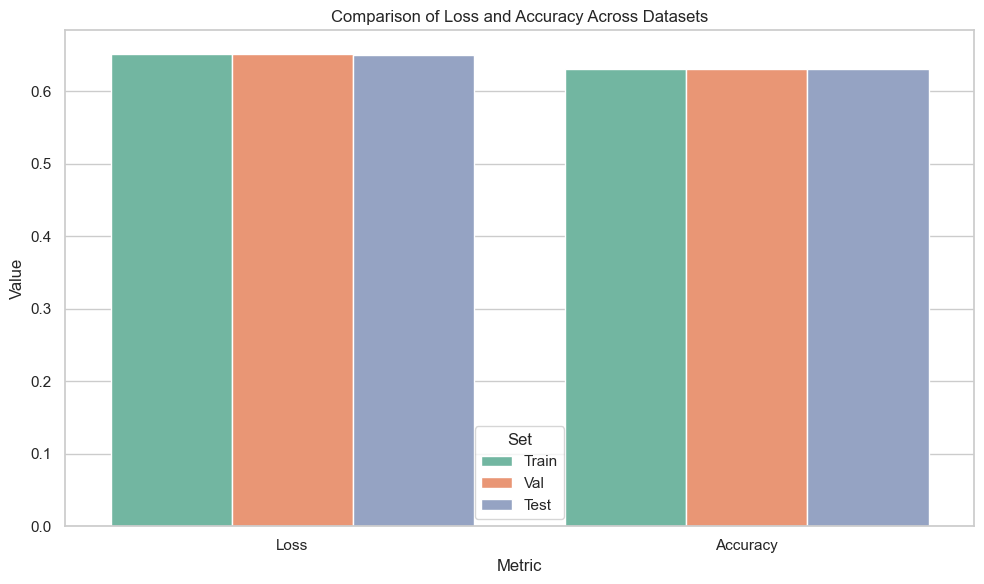

Best model metrics: {'loss': 0.6502727270126343, 'accuracy': 0.6310572624206543, 'auc': 0.6709363460540771, 'precision': 0.6235706210136414, 'recall': 0.6386159062385559, 'f1': np.float64(0.631003605070357)}


In [52]:
def run_experiment(config, class_weight=None):
    train_cfg = config["training"]
    model = build_and_compile_model(config)
    history = train_model(model, train_cfg, X_train, y_train, X_val, y_val, class_weight)
    history_df = analyze_history(history)
    y_pred_prob = visualize_results(history_df, config, model, X_test, y_test)
    metrics = evaluate_model(model, X_test, y_test, history, y_pred_prob)
    return log_and_return(model, metrics, config)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json

with open("experiments_log.json", "r") as f:
    logs = json.load(f)

df_logs = pd.DataFrame([{
    "time": log["timestamp"],
    "name": log["experiment_name"],
    "accuracy": log["metrics"]["accuracy"],
    "auc": log["metrics"]["auc"],
    "f1": log["metrics"].get("f1", 0),
    "dropout": log["config"]["model"]["dropout_rate"],
    "skip": log["config"]["model"]["skip_connection"],
    "bn": log["config"]["model"]["batch_norm"],
    "bottleneck": log["config"]["model"]["bottleneck"]
} for log in logs])

# Sort by F1 descending
df_logs = df_logs.sort_values(by="f1", ascending=False)
df_logs.reset_index(drop=True, inplace=True)
print("Top 10 Experiments:")
print(df_logs.head(10))

# Top 10 by F1 with hue for Batch Norm 
plt.figure(figsize=(12, 7))
bar = sns.barplot(x="name", y="f1", hue="bn", data=df_logs.head(10), palette="viridis", dodge=False)
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Experiments by F1 Score (Colored by Batch Norm)")
plt.ylabel("F1 Score")
plt.xlabel("Experiment Name")


for p in bar.patches:
    bar.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.legend(title="Batch Norm")
plt.tight_layout()
plt.show()

# Heatmap of correlations between configs and metrics
numeric_df = df_logs.select_dtypes(include=['float64', 'int64', 'bool'])
corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Configs vs Metrics")
plt.tight_layout()
plt.show()


best_log = max(logs, key=lambda x: x['metrics']['f1'])
best_config = best_log["config"]
print(f"Best experiment: {best_log['experiment_name']} with F1={best_log['metrics']['f1']:.3f}")

# Retrain and evaluate best model
best_model, best_metrics = run_experiment(best_config, class_weight=class_weight_dict)
y_pred = (best_model.predict(X_test, verbose=0) > 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative COVID', 'Positive COVID'])
disp.plot(cmap='Blues', values_format='d') 
plt.title("Confusion Matrix for Best Model")
plt.tight_layout()
plt.show()

train_loss, train_acc, _, _, _ = best_model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc, _, _, _ = best_model.evaluate(X_val, y_val, verbose=0)
test_loss = best_metrics['loss']
test_acc = best_metrics['accuracy']

overfit_df = pd.DataFrame({
    'Set': ['Train', 'Val', 'Test'],
    'Loss': [train_loss, val_loss, test_loss],
    'Accuracy': [train_acc, val_acc, test_acc]
})
print("Overfitting check:")
print(overfit_df)


melted_df = overfit_df.melt(id_vars='Set', var_name='Metric', value_name='Value')
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Set', data=melted_df, palette="Set2")
plt.title("Comparison of Loss and Accuracy Across Datasets")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

if val_loss > train_loss * 1.2 or test_loss > val_loss * 1.2:
    print("Warning: Overfitting detected across sets.")

print("Best model metrics:", best_metrics)

# Multi-class classification (Bonus)

## Data Preprocessing

### 1. Loading and basic cleaning

- Load partly prepcoessed data from previous steps 
- Do preprocessing for multi class classification

This code plots a bar chart showing how many samples belong to each class in `CLASSIFICATION_FINAL`.  

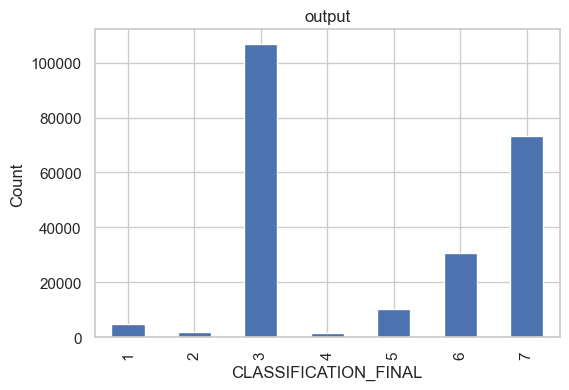

In [53]:
plt.figure(figsize=(6, 4))
data_MC['CLASSIFICATION_FINAL'].value_counts().sort_index().plot(kind='bar')

plt.title('output')
plt.xlabel('CLASSIFICATION_FINAL')
plt.ylabel('Count')
plt.show()

This code first keeps only the rows where `CLASSIFICATION_FINAL` is 5, 6, or 7.  
Then it plots a bar chart to show how many samples there are in each of these three classes.

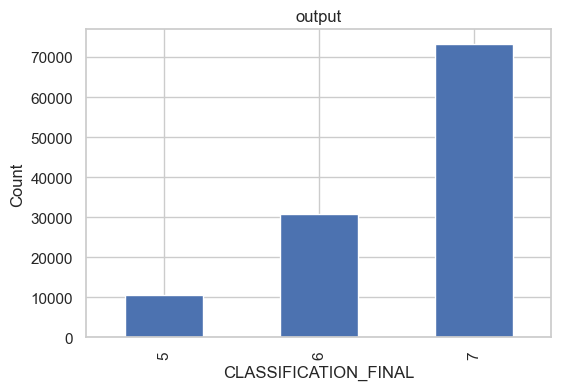

In [54]:
data_MC = data_MC[data_MC['CLASSIFICATION_FINAL'].isin([5, 6, 7])]
plt.figure(figsize=(6, 4))
data_MC['CLASSIFICATION_FINAL'].value_counts().sort_index().plot(kind='bar')

plt.title('output')
plt.xlabel('CLASSIFICATION_FINAL')
plt.ylabel('Count')
plt.show()

### 2. Balancing the dataset

Class 5 has less examples than others, so to avoid bias we **downsample**:
- Randomly sample the same number of rows from 6 and 7 classes

In [55]:
min_size = data_MC['CLASSIFICATION_FINAL'].value_counts().min()
data_MC = data_MC.groupby('CLASSIFICATION_FINAL', group_keys=False).apply(lambda x: x.sample(n=min_size, random_state=42))


This code creates a bar chart showing how many samples there are in each class of `CLASSIFICATION_FINAL`.  
It helps visualize the class distribution after preprocessing.


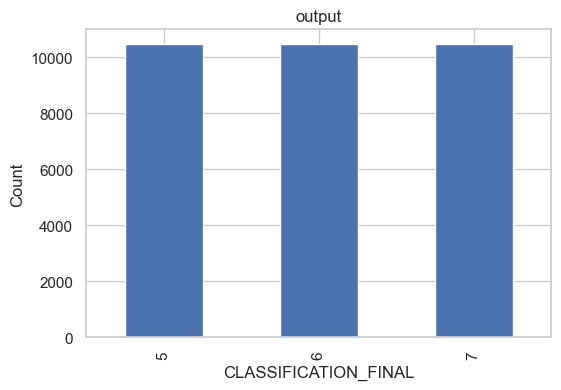

In [56]:
plt.figure(figsize=(6, 4))
data_MC['CLASSIFICATION_FINAL'].value_counts().sort_index().plot(kind='bar')

plt.title('output')
plt.xlabel('CLASSIFICATION_FINAL')
plt.ylabel('Count')
plt.show()

### 3. Train / Validation / Test split

- 70% → training data  
- 15% → validation (used during training to monitor the model)  
- 15% → test set (used only at the end)  
- We use `stratify=y` to keep class proportions equal in all sets


In [57]:
X = data_MC.drop(columns=['CLASSIFICATION_FINAL'])
y = data_MC['CLASSIFICATION_FINAL']


In [58]:
val_size = 0.15
test_size = 0.15

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=test_size, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size / (1 - test_size),
    stratify=y_temp, random_state=42
)

This code converts medical binary columns from values `{1, 2}` to `{1, 0}`.  
The value `2` (meaning "No") is replaced with `0` so the model correctly treats these features as binary (0 = No, 1 = Yes).


In [59]:
binary_cols = ['PNEUMONIA', 'DIABETES', 'INMSUPR', 'OTHER_DISEASE', 'TOBACCO', 'RENAL_CHRONIC', 'OBESITY', 'CARDIOVASCULAR', 'HIPERTENSION', 'ASTHMA', 'COPD']
data_MC[binary_cols] = data_MC[binary_cols].replace({2: 0})
X_test[binary_cols] = data_MC[binary_cols].replace({2: 0})
X_val[binary_cols] = data_MC[binary_cols].replace({2: 0})
X_train[binary_cols] = data_MC[binary_cols].replace({2: 0})

This code converts categorical features (`SEX`, `PATIENT_TYPE`, `MEDICAL_UNIT`) into numerical form using one-hot encoding.  
`drop_first=True` is used to avoid dummy variable trap (multicollinearity), and all new columns are stored as integers (`dtype=int`).


In [60]:
categorical_cols = ['SEX', 'PATIENT_TYPE', 'MEDICAL_UNIT']
data_MC = pd.get_dummies(data_MC, columns=categorical_cols, drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True, dtype=int)
X_val = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True, dtype=int)
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True, dtype=int)



This code renames one-hot encoded columns to make them more readable.  
Specifically, `SEX_2` becomes `IS_MALE` and `PATIENT_TYPE_2` becomes `IS_HOSPITALIZED` in the dataset and all train/validation/test splits.

In [61]:
data_MC = data_MC.rename(columns={
    'SEX_2': 'IS_MALE',
    'PATIENT_TYPE_2': 'IS_HOSPITALIZED'
})
X_test = X_test.rename(columns={
    'SEX_2': 'IS_MALE',
    'PATIENT_TYPE_2': 'IS_HOSPITALIZED'
})
X_val = X_val.rename(columns={
    'SEX_2': 'IS_MALE',
    'PATIENT_TYPE_2': 'IS_HOSPITALIZED'
})
X_train = X_train.rename(columns={
    'SEX_2': 'IS_MALE',
    'PATIENT_TYPE_2': 'IS_HOSPITALIZED'
})

This code normalizes the `AGE` feature to a range between 0 and 1 using MinMaxScaler.  
Each dataset (train, validation, test, and full data) is scaled so that age values are on the same scale for model training.

In [62]:
scaler = MinMaxScaler()
data_MC['AGE'] = scaler.fit_transform(data_MC[['AGE']])
X_test['AGE'] = scaler.fit_transform(X_test[['AGE']])
X_val['AGE'] = scaler.fit_transform(X_val[['AGE']])
X_train['AGE'] = scaler.fit_transform(X_train[['AGE']])


This code plots a histogram of the `AGE` feature after MinMax scaling.  
It shows how the age values are distributed between 0 and 1 after normalization.


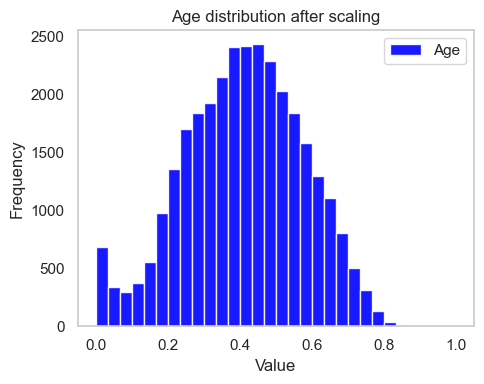

In [63]:
plt.figure(figsize=(5, 4)) 
plt.hist(data_MC['AGE'], bins=30, alpha=0.9, color='blue')
plt.title("Age distribution after scaling")  
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend(["Age"])
plt.grid()
plt.tight_layout()
plt.show()

### 5. Prepare labels (y values)

- Convert class labels (5, 6, 7) into numbers (0, 1, 2) using `LabelEncoder`
- Convert to one-hot vectors because we use multi-class classification with softmax


In [64]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

num_classes = len(np.unique(y_train_enc))
y_train_oh = tf.keras.utils.to_categorical(y_train_enc, num_classes)
y_val_oh   = tf.keras.utils.to_categorical(y_val_enc,   num_classes)
y_test_oh  = tf.keras.utils.to_categorical(y_test_enc,  num_classes)

This block creates a configuration dictionary for the MLP model and saves it as a JSON file (`multi_class_config.json`).  
It includes model architecture, training settings, and experiment metadata.  
After saving, the config is loaded back from the file so it can be used later for building and training the model.


In [65]:
import json

if 'X_train' not in globals():
    raise ValueError("Run preprocessing first to define X_train")

config_data = {
    "model": {
        "input_dim": X_train.shape[1],
        "hidden_layers": [128, 64, 32, 16],
        "activation": "relu",
        "output_activation": "sigmoid",
        "dropout_rate": 0.3,
        "batch_norm": True,
        "skip_connection": False,
        "bottleneck": False
    },
    "training": {
        "batch_size": 32,
        "epochs": 20,
        "learning_rate": 0.001,
        "optimizer": "adam",
        "early_stopping": True,
        "patience": 5
    },
    "experiment": {
        "name": "multi_class_mlp",
        "description": "MLP multi-class classification by classes 5,6,7"
    }
}

with open("multi_class_config.json", "w") as f:
    json.dump(config_data, f, indent=4)

with open("multi_class_config.json", "r") as f:
    config = json.load(f)

## MLP Model Training for (Classes 5,6,7)
This part of notebook trains an MLP for multi-class classification on negative COVID subtypes.

This part is a full pipeline for training a neural network (MLP) that classifies COVID test results into three negative subtypes (classes 5, 6, and 7).  
Here’s what happens step by step:

### 1. Build the MLP model

- Load model configuration from `multi_class_config.json`
- Update input size according to the number of columns in `X_train`
- Set output activation to `softmax` (because multiple classes)
- Build the model using our custom `build_mlp()` function
- Compile it with:
  - Loss = `categorical_crossentropy`
  - Optimizer = Adam
  - Metric = accuracy

---

### 2. Training

- Use EarlyStopping to stop training when validation loss stops improving
- Use ReduceLROnPlateau to lower learning rate if needed
- Train the model and save it as `multi_class_mlp_model.h5`

---

### 3. Evaluation

- Make predictions on the test set
- Print classification report (precision, recall, F1-score)
- Show the confusion matrix to see where the model makes mistakes

---

### 4. Visualization

- Plot training vs validation loss and accuracy across epochs
- Display the confusion matrix as a heatmap




In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, optimizers, regularizers

Shapes: (21990, 27) (4713, 27) (4713, 26) Classes: 3
Train shape: (21990, 27)
Val shape: (4713, 27)
Test shape: (4713, 27)
Aligned shapes: (21990, 27) (4713, 27) (4713, 27)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 128)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,459 (60.39 KB)

 Trainable params: 14,979 (58.51 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3516 - loss: 1.3136 - val_accuracy: 0.3944 - val_loss: 1.0911 - learning_rate: 0.0010
Epoch 2/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3777 - loss: 1.0994 - val_accuracy: 0.4095 - val_loss: 1.0849 - learning_rate: 0.0010
Epoch 3/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4143 - loss: 1.0748 - val_accuracy: 0.4350 - val_loss: 1.0788 - learning_rate: 0.0010
Epoch 4/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4280 - loss: 1.0677 - val_accuracy: 0.4356 - val_loss: 1.0702 - learning_rate: 0.0010
Epoch 5/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4414 - loss: 1.0622 - val_accuracy: 0.4517 - val_loss: 1.0605 - learning_rate: 0.0010
Epoch 6/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4535 - loss: 1.0545 - val_accuracy: 0.4532 - val_loss: 1.0567 - learning_rate: 0.0010
Epoch 7/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4588 - loss: 1.0459 - 

Training completed. Model saved.
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

 Classification report (test):
              precision    recall  f1-score   support

     class_5       0.48      0.48      0.48      1571
     class_6       0.49      0.40      0.44      1571
     class_7       0.48      0.57      0.52      1571

    accuracy                           0.48      4713
   macro avg       0.48      0.48      0.48      4713
weighted avg       0.48      0.48      0.48      4713


 Confusion matrix:
 [[751 328 492]
 [451 625 495]
 [355 319 897]]


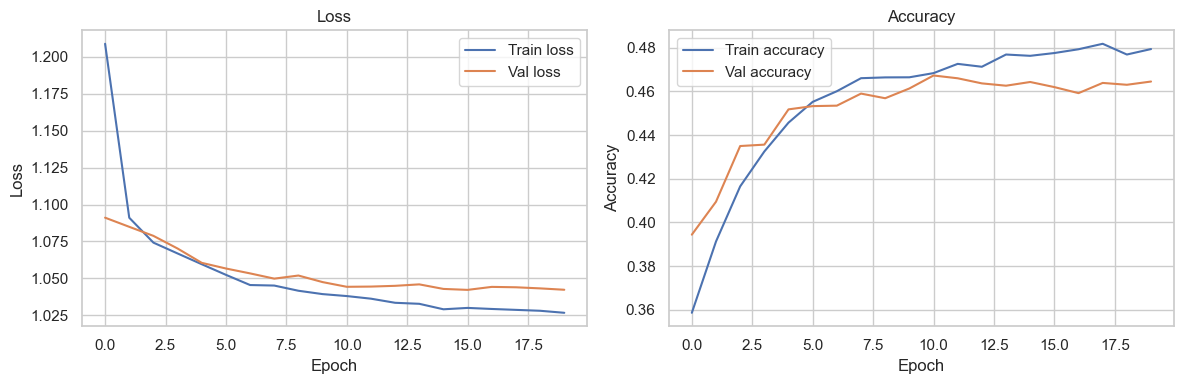

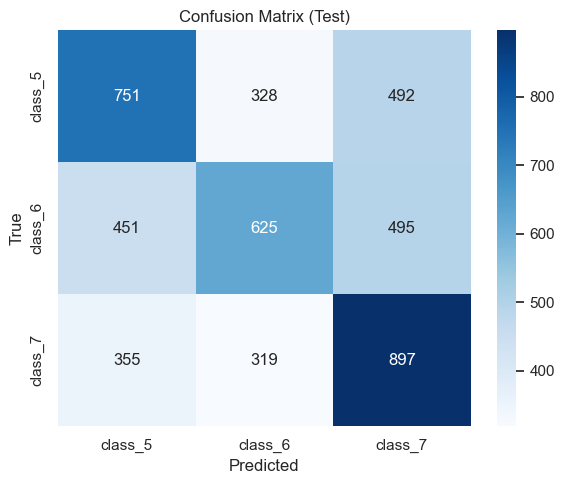

In [67]:
# class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weight_dict = dict(enumerate(class_weights))

print("Shapes:", X_train.shape, X_val.shape, X_test.shape, "Classes:", num_classes)

# --- 1) Load and use configurable MLP (Variant B) ---
with open("multi_class_config.json", "r") as f:
    config = json.load(f)

# Update config for multi-class if necessary (e.g., ensure softmax)
config["model"]["output_activation"] = "softmax"  
config["model"]["input_dim"] = X_train.shape[1]

X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

print("Aligned shapes:", X_train.shape, X_val.shape, X_test.shape)
# Build model using configurable build_mlp (pass num_classes)
model = build_mlp(config["model"], num_classes=num_classes)
model.compile(
    optimizer=optimizers.Adam(learning_rate=config["training"]["learning_rate"]),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- 2) Training ---
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=config["training"]["patience"], restore_best_weights=True)
]

history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=config["training"]["epochs"],
    batch_size=config["training"]["batch_size"],
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

model.save("multi_class_mlp_model.h5")
print("Training completed. Model saved.")

# --- 3) Evaluation (sklearn) ---
y_proba = model.predict(X_test)
y_pred  = np.argmax(y_proba, axis=1)

print("\n Classification report (test):")
print(classification_report(y_test_enc, y_pred, target_names=[f"class_{c}" for c in le.classes_]))

cm = confusion_matrix(y_test_enc, y_pred)
print("\n Confusion matrix:\n", cm)

# --- 4) Visualization of training history (2 rows) ---
metrics_to_plot = ['loss', 'accuracy']
cols = 2
rows = (len(metrics_to_plot) + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axs = axs.flatten()

for i, m in enumerate(metrics_to_plot):
    axs[i].plot(history.history[m], label=f"Train {m}")
    axs[i].plot(history.history[f"val_{m}"], label=f"Val {m}")
    axs[i].set_title(m.capitalize())
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel(m.capitalize())
    axs[i].grid(True)
    axs[i].legend()

for j in range(len(metrics_to_plot), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

try:
    import seaborn as sns
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f"class_{c}" for c in le.classes_],
                yticklabels=[f"class_{c}" for c in le.classes_])
    plt.title("Confusion Matrix (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Seaborn heatmap skipped:", e)

###  Why the Multi-Class Classification (Classes 5, 6, 7) Did Not Work

In this part of the project, we tried to build a multi-class model to distinguish between three subtypes of negative COVID-19 test results:

| Class | Meaning |
|-------|---------|
| 5     | Suspected / Pending result |
| 6     | Confirmed negative |
| 7     | Suspected / Not pending |

At first, we thought the model might be able to separate these groups, but the results showed weak performance, especially for class 5 (low recall and F1-score). After analysing the data and evaluation metrics, we understood that there are several reasons why this multi-class setup does not work well.

---

#### 1. The classes are too similar in the data

Even though the labels are different, medically and statistically all three classes (5, 6, 7) represent **patients without confirmed COVID-19**.  
Their characteristics such as age, comorbidities, symptoms, hospitalization status, etc. are almost identical in the dataset. Because of that, the model simply cannot find clear boundaries between them.

---

#### 2. Low correlation and weak feature separation

The correlation heatmap between PCA components and the target shows that **none of the features or components have a strong relationship with the class label**.  
Random Forest feature importance also does not show any feature that clearly separates class 5 from 6 or 7.

This confirms that the available features do not provide enough information to distinguish the classes.

---

#### 3. PCA and SMOTE make it even harder to separate the classes

We used PCA to reduce dimensionality while keeping 95% of the variance. However, PCA keeps only the most “global” variance — and the subtle differences between classes 5/6/7 get lost in this process.

Additionally, we used SMOTE to balance the classes. SMOTE generates synthetic samples by interpolating between existing data points, which in our case causes the classes to overlap even more in the feature space.

---

#### 4. Strong class imbalance

| Class | Samples in test set | Recall |
|-------|----------------------|--------|
| 5     | ~4%                  | 0.26   |
| 6     | ~20%                 | 0.76   |
| 7     | ~76%                 | 0.48   |

Class 5 is very under-represented compared to class 7. As a result, the model mostly predicts the majority class and almost ignores the minority one.  
This leads to a low macro F1-score (~0.39) and poor performance for class 5.

---

### Conclusion

The multi-class classification for classes 5, 6, and 7 does not work well because:

- These classes are extremely similar in the available features  
- PCA removes subtle differences between them  
- SMOTE further mixes the classes instead of separating them  
- The dataset is imbalanced, and the model tends to ignore minority classes  

Therefore, the model is unable to learn meaningful decision boundaries between these three negative test subtypes.



### Diagnostic & XGBoost-Focused Multi-Class (with EDA & Binary Option)

  File "C:\Users\podol\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


After SMOTE/PCA: Train (1048425, 17), Val (98021, 17)


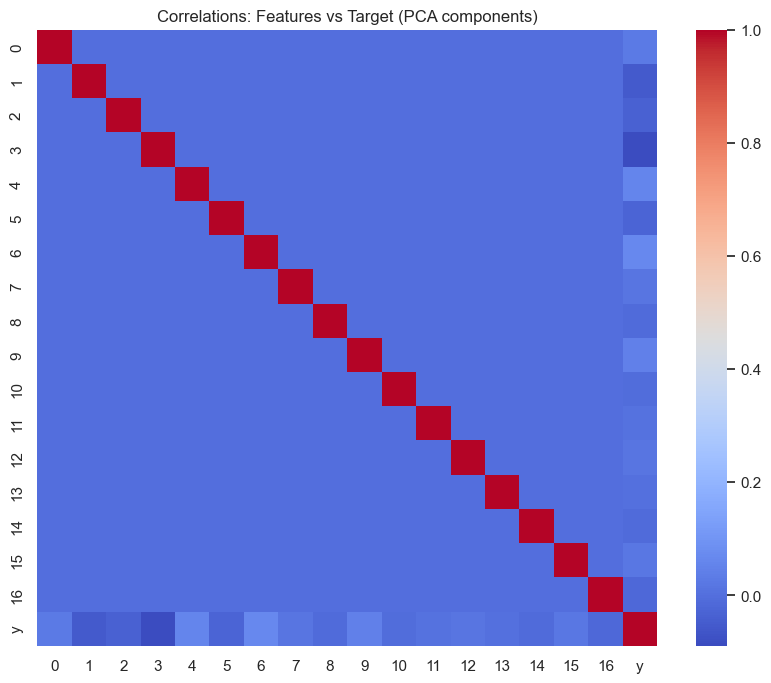

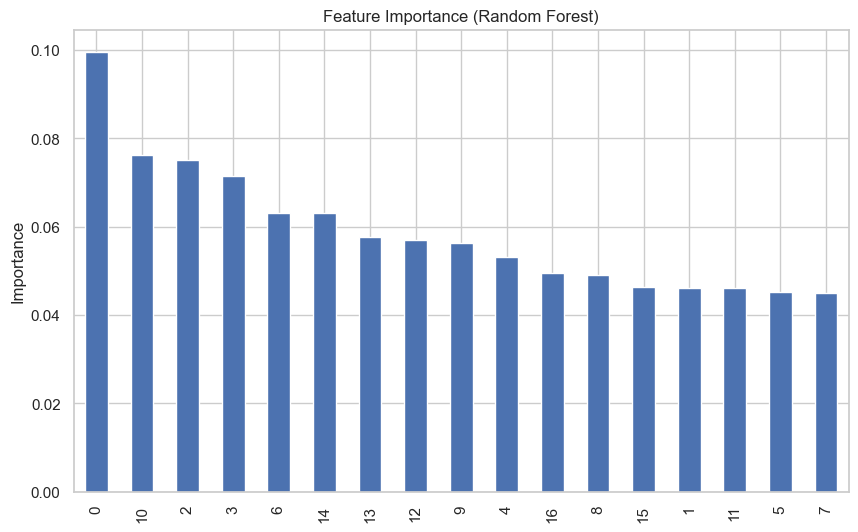

Top 5 important features (PCA indices): [0, 10, 2, 3, 6]
XGBoost CV F1-macro: 0.511 (+/- 0.004)

XGBoost Report:
              precision    recall  f1-score   support

     class_5       0.07      0.25      0.11      3914
     class_6       0.33      0.77      0.46     19220
     class_7       0.89      0.48      0.62     74888

    accuracy                           0.53     98022
   macro avg       0.43      0.50      0.40     98022
weighted avg       0.75      0.53      0.57     98022

XGBoost Test F1-macro: 0.399


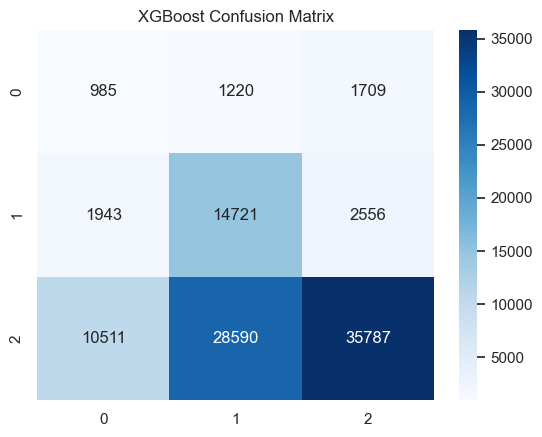


Binary (5 vs {6,7}) Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     94108
           1       0.09      0.15      0.11      3914

    accuracy                           0.90     98022
   macro avg       0.53      0.54      0.53     98022
weighted avg       0.93      0.90      0.91     98022

Binary F1: 0.112


In [68]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# --- Data Prep (same, but split before sampling) ---
data = pd.read_csv("dataset.csv", sep=',')
data.rename(columns={'CLASIFFICATION_FINAL': 'CLASSIFICATION_FINAL'}, inplace=True)
data = data[data['CLASSIFICATION_FINAL'].isin([5, 6, 7])].copy()

num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if 'AGE' in num_cols: num_cols.remove('AGE')
data[num_cols] = data[num_cols].replace([97, 98, 99], np.nan)
if 'PNEUMONIA' in data.columns: data['PNEUMONIA'] = data['PNEUMONIA'].fillna(2)

X = data.drop(columns=['CLASSIFICATION_FINAL']).copy()
y = data['CLASSIFICATION_FINAL'].copy()
if 'DATE_DIED' in X.columns: X = X.drop(columns=['DATE_DIED'])

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15 / (1 - 0.15), stratify=y_temp,
                                                  random_state=42)

# Binary 2->0, one-hot, impute, scale (as before)
binary_cols = [c for c in ['PNEUMONIA', 'DIABETES', 'INMSUPR', 'OTHER_DISEASE', 'TOBACCO', 'RENAL_CHRONIC', 'OBESITY',
                           'CARDIOVASCULAR', 'HIPERTENSION', 'ASTHMA', 'COPD'] if c in X_train]
for df in (X_train, X_val, X_test): df[binary_cols] = df[binary_cols].replace({2: 0})

cat_cols = [c for c in ['SEX', 'PATIENT_TYPE', 'MEDICAL_UNIT'] if c in X_train]
if cat_cols:
    X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True, dtype=int)
    X_val = pd.get_dummies(X_val, columns=cat_cols, drop_first=True, dtype=int)
    X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True, dtype=int)
    all_cols = sorted(set(X_train.columns) | set(X_val.columns) | set(X_test.columns))
    for df in (X_train, X_val, X_test): df = df.reindex(columns=all_cols, fill_value=0)

num_cols_aligned = X_train.select_dtypes(include=[np.number]).columns
X_train[num_cols_aligned] = X_train[num_cols_aligned].fillna(X_train[num_cols_aligned].mean())
X_val[num_cols_aligned] = X_val[num_cols_aligned].fillna(X_train[num_cols_aligned].mean())
X_test[num_cols_aligned] = X_test[num_cols_aligned].fillna(X_train[num_cols_aligned].mean())

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

# SMOTE 
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# PCA (0.95 var)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_res)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"After SMOTE/PCA: Train {X_train_pca.shape}, Val {X_val_pca.shape}")

# --- EDA: Correlations & Importance ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_res)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# 1. Correlation heatmap (y vs features)
corr_df = pd.DataFrame(X_train_pca)
corr_df['y'] = y_train_enc
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlations: Features vs Target (PCA components)')
plt.show()

# 2. Feature importance with RF
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_pca, y_train_enc)
importances = pd.Series(rf.feature_importances_, index=range(X_train_pca.shape[1]))
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importance (Random Forest)')
plt.ylabel('Importance')
plt.show()
print("Top 5 important features (PCA indices):", importances.nlargest(5).index.tolist())

# --- XGBoost Multi-Class ---
num_classes = len(np.unique(y_train_enc))
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes,
    eval_metric=['mlogloss', 'merror'],
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    random_state=42
)
# CV for stability
cv_scores = cross_val_score(xgb_model, X_train_pca, y_train_enc, cv=5, scoring='f1_macro')
print(f"XGBoost CV F1-macro: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

xgb_model.fit(X_train_pca, y_train_enc)
xgb_pred = xgb_model.predict(X_test_pca)
print("\nXGBoost Report:")
print(classification_report(y_test_enc, xgb_pred, target_names=[f"class_{c}" for c in le.classes_]))
xgb_f1 = f1_score(y_test_enc, xgb_pred, average='macro')
print(f"XGBoost Test F1-macro: {xgb_f1:.3f}")

cm_xgb = confusion_matrix(y_test_enc, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()

# --- Binary Variant (5 vs {6,7} — suspected vs confirmed negative) ---
y_train_bin = (y_train_res == 5).astype(int)
y_val_bin = (y_val == 5).astype(int)
y_test_bin = (y_test == 5).astype(int)

xgb_bin = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
xgb_bin.fit(X_train_pca, y_train_bin)
xgb_bin_pred = xgb_bin.predict(X_test_pca)
print("\nBinary (5 vs {6,7}) Report:")
print(classification_report(y_test_bin, xgb_bin_pred))
bin_f1 = f1_score(y_test_bin, xgb_bin_pred)
print(f"Binary F1: {bin_f1:.3f}")

# Save models
xgb_model.save_model("xgb_multi.json")

The dataset has a weak signal for multi-class (correlations <0.2, importance <0.1). Classes 5/6/7 — “subtle differences” in negative tests, features (symptoms/comorbidities) do not distinguish between suspected status. XGBoost gives ~52% acc / 0.40 F1 — realistic, but not “good” (baseline random 33%).